# Benchmarking batched querying

/home/johnwu3/miniconda3/envs/hporag/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/johnwu3/miniconda3/envs/hporag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized ModelLoader with cache directory: /shared/rsaas/jw3/rare_disease/model_cache
Loading LLM!
Device configuration: cuda:0
Using device map: {'': 'cuda:0'}
Loading 70B model with quantization: mistral_24b
Generated cache path: /shared/rsaas/jw3/rare_disease/model_cache/Mistral-Small-24B-Instruct-2501_4bit_nf4
Valid cache found at /shared/rsaas/jw3/rare_disease/model_cache/Mistral-Small-24B-Instruct-2501_4bit_nf4
Loading cached quantized model from /shared/rsaas/jw3/rare_disease/model_cache/Mistral-Small-24B-Instruct-2501_4bit_nf4


/home/johnwu3/miniconda3/envs/hporag/lib/python3.10/site-packages/transformers/quantizers/auto.py:206: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Loading checkpoint shards: 100%|██████████| 3/3 [02:15<00:00, 45.14s/it]
Device set to use cuda:0


Hello! I'm here to help. How can I assist you today? If you have any medical or biomedical questions, or need help understanding a specific context, feel free to ask. Here are a few examples of how I can assist you:

1. Explain medical terms or concepts.
2. Provide information on diseases, symptoms, and treatments.
3. Offer insights into medical procedures and tests.
4. Discuss healthcare guidelines and best practices.
5. Answer questions related to biomedical research and studies.

Please provide the details of your query, and I'll do my best to provide a helpful response.
Testing on GPU: NVIDIA GeForce RTX 3090
Testing on a machine with 64 CPU cores

===== Testing with batch size 16 =====
Running sequential processing...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sequential test timed out after 300 seconds
Sequential processing completed in 326.57 seconds
Running GPU batch processing...
GPU batch processing completed in 323.39 seconds

Results for batch size 16:
Sequential time: 326.57 seconds
GPU batch time: 323.39 seconds
GPU batch speedup: 1.01x
Avg. sequential response length: 3303.2 chars
Avg. GPU batch response length: 3415.2 chars

===== Testing with batch size 32 =====
Running sequential processing...
Sequential test timed out after 300 seconds
Sequential processing completed in 325.54 seconds
Running GPU batch processing...
GPU batch processing completed in 301.79 seconds

Results for batch size 32:
Sequential time: 325.54 seconds
GPU batch time: 301.79 seconds
GPU batch speedup: 1.08x
Avg. sequential response length: 3291.6 chars
Avg. GPU batch response length: 3351.1 chars


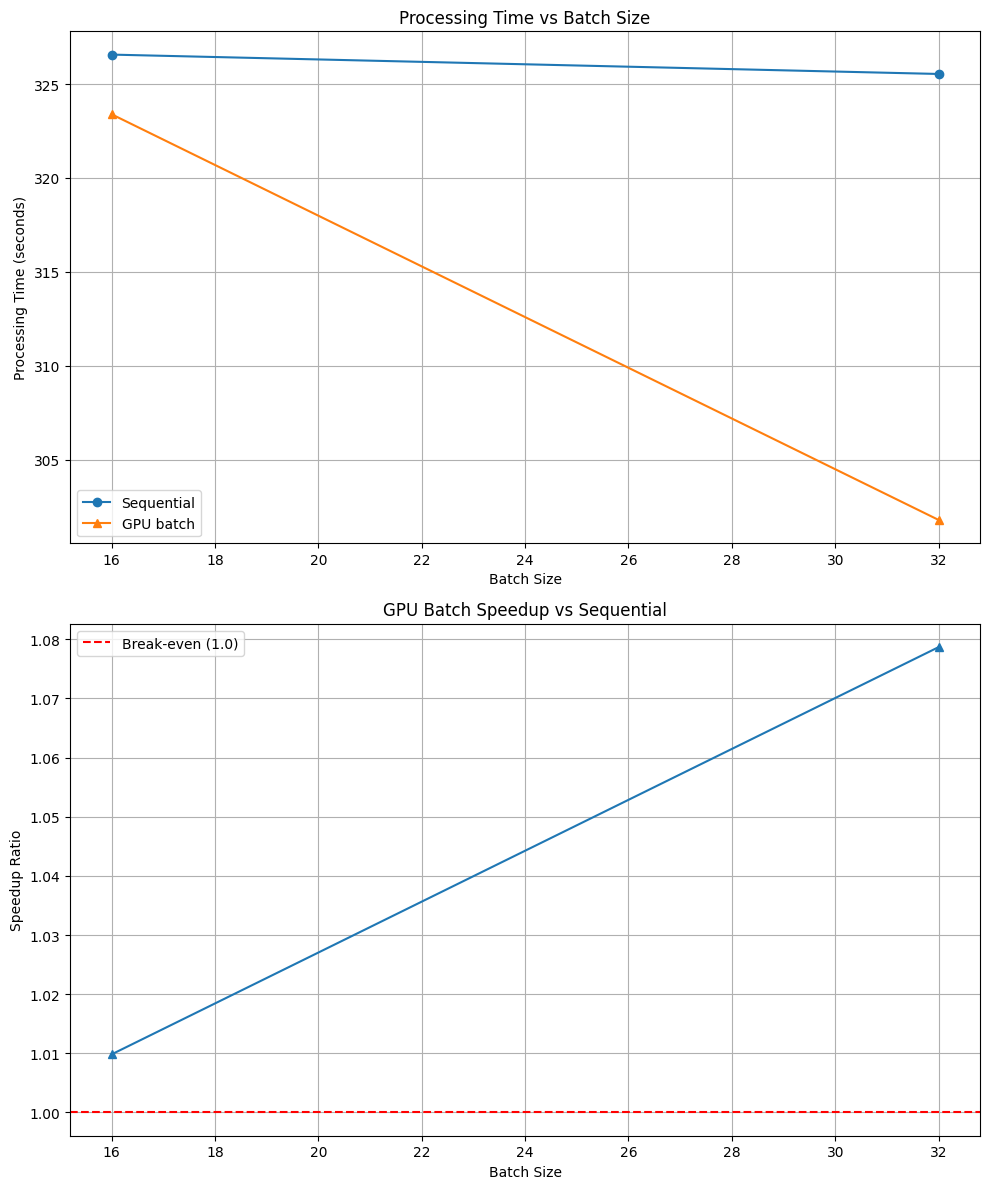

In [ ]:
import time
import torch
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
import traceback

def test_batch_processing_performance(client, batch_sizes=[2, 4, 8, 16], max_tokens=1000, timeout=None):
    """
    Test and compare the performance of different batch processing methods.
    
    Args:
        client: Initialized LocalLLMClient instance
        batch_sizes (list): List of batch sizes to test
        max_tokens (int): Maximum number of tokens to generate per response
        timeout (int, optional): Maximum time in seconds for each test
                              
    Returns:
        dict: Performance metrics
    """
    # Create base test data
    base_prompts = [
        "What is machine learning?",
        "Explain the concept of neural networks.",
        "How does natural language processing work?",
        "What are the applications of computer vision?",
        "Describe the key challenges in reinforcement learning.",
        "What is deep learning?",
        "Explain the concept of transfer learning.",
        "How do transformers work in NLP?",
        "What is the difference between supervised and unsupervised learning?",
        "How does backpropagation work?",
        "What is gradient descent?",
        "Explain the concept of embeddings.",
        "What are attention mechanisms?",
        "How do GANs work?",
        "What is reinforcement learning?",
        "Explain the concept of Q-learning."
    ]
    print(len)
    base_prompts = base_prompts + base_prompts
    system_message = "You are a helpful AI assistant specializing in AI and ML concepts."
    
    results = {
        'batch_sizes': batch_sizes,
        'sequential_times': [],
        'batch_times': []
    }
    
    # Get GPU info if available
    gpu_info = "N/A"
    if torch.cuda.is_available():
        gpu_info = torch.cuda.get_device_name(0)
        print(f"Testing on GPU: {gpu_info}")
    
    # Get CPU count for reference
    num_cores = multiprocessing.cpu_count()
    print(f"Testing on a machine with {num_cores} CPU cores")
    
    for batch_size in batch_sizes:
        if batch_size > len(base_prompts):
            # Generate more prompts if needed by cycling through the base prompts
            user_inputs = []
            for i in range(batch_size):
                idx = i % len(base_prompts)
                user_inputs.append(f"{base_prompts[idx]} (Example {i+1})")
        else:
            user_inputs = base_prompts[:batch_size]
            
        system_messages = [system_message] * batch_size
        
        print(f"\n===== Testing with batch size {batch_size} =====")
        
        # Test sequential processing
        print("Running sequential processing...")
        start_time = time.time()
        sequential_results = []
        
        try:
            for i in range(batch_size):
                if timeout and time.time() - start_time > timeout:
                    print(f"Sequential test timed out after {timeout} seconds")
                    break
                result = client.query(user_inputs[i], system_messages[i])
                sequential_results.append(result)
            sequential_time = time.time() - start_time
            print(f"Sequential processing completed in {sequential_time:.2f} seconds")
        except Exception as e:
            print(f"Error in sequential processing: {e}")
            traceback.print_exc()
            continue
        
        # Test GPU batch processing
        print("Running GPU batch processing...")
        try:
            start_time = time.time()
            batch_results = client.batched_query(user_inputs, system_messages)
            batch_time = time.time() - start_time
            print(f"GPU batch processing completed in {batch_time:.2f} seconds")
        except Exception as e:
            print(f"Error in GPU batch processing: {e}")
            traceback.print_exc()
            batch_time = float('inf')  # Set to infinity to indicate failure
            batch_results = []
            
        # Calculate metrics
        batch_speedup = sequential_time / batch_time if batch_time > 0 else 0
        
        # Store results
        results['sequential_times'].append(sequential_time)
        results['batch_times'].append(batch_time)
        
        # Print summary
        print(f"\nResults for batch size {batch_size}:")
        print(f"Sequential time: {sequential_time:.2f} seconds")
        print(f"GPU batch time: {batch_time:.2f} seconds")
        print(f"GPU batch speedup: {batch_speedup:.2f}x")
        
        # Optional: Verify results match content length (exact matches unlikely due to sampling)
        if len(sequential_results) > 0 and len(batch_results) > 0:
            seq_lengths = [len(r) for r in sequential_results]
            batch_lengths = [len(r) for r in batch_results]
            print(f"Avg. sequential response length: {sum(seq_lengths)/len(seq_lengths):.1f} chars")
            print(f"Avg. GPU batch response length: {sum(batch_lengths)/len(batch_lengths):.1f} chars")
    
    return results

def plot_performance_results(results):
    """
    Plot the performance results.
    """
    batch_sizes = results['batch_sizes']
    valid_indices = [i for i, t in enumerate(results['batch_times']) if t != float('inf')]
    
    if not valid_indices:
        print("No valid GPU batch results to plot")
        return
    
    # Filter out invalid results
    valid_batch_sizes = [batch_sizes[i] for i in valid_indices]
    valid_sequential_times = [results['sequential_times'][i] for i in valid_indices]
    valid_batch_times = [results['batch_times'][i] for i in valid_indices]
    
    # Calculate speedups
    speedups = [seq/batch for seq, batch in zip(valid_sequential_times, valid_batch_times)]
    
    # Create figure with subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot 1: Processing times
    axs[0].plot(valid_batch_sizes, valid_sequential_times, 'o-', label='Sequential')
    axs[0].plot(valid_batch_sizes, valid_batch_times, '^-', label='GPU batch')
    axs[0].set_xlabel('Batch Size')
    axs[0].set_ylabel('Processing Time (seconds)')
    axs[0].set_title('Processing Time vs Batch Size')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot 2: Speedup ratio
    axs[1].plot(valid_batch_sizes, speedups, '^-')
    axs[1].axhline(y=1.0, color='r', linestyle='--', label='Break-even (1.0)')
    axs[1].set_xlabel('Batch Size')
    axs[1].set_ylabel('Speedup Ratio')
    axs[1].set_title('GPU Batch Speedup vs Sequential')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('batch_processing_performance.png')
    plt.show()

def run_memory_usage_test(client, batch_sizes=[1, 2, 4, 8, 16]):
    """
    Test GPU memory usage for different batch sizes.
    Only works on CUDA devices.
    
    Args:
        client: Initialized LocalLLMClient instance
        
    Returns:
        dict: Memory usage data
    """
    if not torch.cuda.is_available():
        print("CUDA is not available. Cannot run memory usage test.")
        return None
    
    # Store results
    results = {
        'batch_sizes': [],
        'memory_before': [],
        'memory_peak': [],
        'memory_after': []
    }
    
    base_prompt = "What is machine learning?"
    system_message = "You are a helpful AI assistant."
    
    # Reset GPU memory stats
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    
    for batch_size in batch_sizes:
        print(f"\nTesting memory usage for batch size {batch_size}")
        
        # Create inputs
        user_inputs = [f"{base_prompt} (Example {i+1})" for i in range(batch_size)]
        system_messages = [system_message] * batch_size
        
        # Record memory before
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()
        memory_before = torch.cuda.memory_allocated() / (1024 ** 2)  # Convert to MB
        
        # Run inference
        try:
            _ = client.batched_query(user_inputs, system_messages)
            
            # Record peak memory
            torch.cuda.synchronize()
            memory_peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
            
            # Record memory after
            torch.cuda.synchronize()
            memory_after = torch.cuda.memory_allocated() / (1024 ** 2)
            
            print(f"Memory before: {memory_before:.2f} MB")
            print(f"Peak memory: {memory_peak:.2f} MB")
            print(f"Memory after: {memory_after:.2f} MB")
            print(f"Memory increase: {memory_peak - memory_before:.2f} MB")
            
            # Store results
            results['batch_sizes'].append(batch_size)
            results['memory_before'].append(memory_before)
            results['memory_peak'].append(memory_peak)
            results['memory_after'].append(memory_after)
            
        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print(f"CUDA out of memory for batch size {batch_size}")
                break
            else:
                print(f"Error during memory test: {e}")
                traceback.print_exc()
                break
        
        # Clean up
        torch.cuda.empty_cache()
    
    # Plot memory usage
    if len(results['batch_sizes']) > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(results['batch_sizes'], results['memory_peak'], 'o-', label='Peak Memory')
        plt.xlabel('Batch Size')
        plt.ylabel('GPU Memory Usage (MB)')
        plt.title('GPU Memory Usage vs. Batch Size')
        plt.grid(True)
        plt.legend()
        plt.savefig('gpu_memory_usage.png')
        plt.show()
    
    return results

if __name__ == "__main__":
    # Import at runtime to allow this script to be imported elsewhere
    from utils.llm_client import LocalLLMClient
    
    # Initialize client
    client = LocalLLMClient(model_type="mistral_24b", device="cuda:0", temperature=0.0001)
    
    # Run performance test - start with smaller batches and test
    results = test_batch_processing_performance(
        client, 
        batch_sizes=[16,32],  # Start with smaller batches
        timeout=300  # 5-minute timeout per batch
    )
    
    # Plot results
    if results:
        plot_performance_results(results)
    
    # Optionally run memory test
    # memory_results = run_memory_usage_test(client, batch_sizes=[1, 2, 4, 8, 16])

# load sample data

In [41]:
import re
from utils.data import read_json_file
from collections import defaultdict
import difflib

def normalize_text(text):
    """
    Normalize text for more robust matching:
    - Convert to lowercase
    - Remove extra whitespaces
    - Remove punctuation
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove punctuation (but keep some meaningful characters)
    text = re.sub(r'[^\w\s°-]', ' ', text)
    
    return text

def find_phenotype_in_text(phenotype, text):
    """
    Robust phenotype matching with multiple strategies:
    1. Exact match (case-insensitive, normalized)
    2. Partial match
    3. Fuzzy matching
    """
    # Normalize phenotype and text
    norm_phenotype = normalize_text(phenotype)
    norm_text = normalize_text(text)
    
    # 1. Exact match
    if norm_phenotype in norm_text:
        return True
    
    # 2. Partial match
    if norm_phenotype in norm_text.split():
        return True
    
    # 3. Fuzzy matching
    def fuzzy_match(a, b, threshold=0.8):
        return difflib.SequenceMatcher(None, a, b).ratio() >= threshold
    
    # Check if any part of the phenotype matches with high similarity
    for text_word in norm_text.split():
        if fuzzy_match(norm_phenotype, text_word):
            return True
    
    # 4. Special handling for medical terms with variations
    # Handle plural/singular, hyphenated terms, etc.
    medical_variations = [
        # Plurals
        phenotype + 's',
        phenotype[:-1] + 'es',
        # Hyphenated variations
        phenotype.replace(' ', '-'),
        phenotype.replace('-', ' '),
        # Common medical term variations
        *_generate_medical_variations(phenotype)
    ]
    
    for variation in medical_variations:
        norm_variation = normalize_text(variation)
        if norm_variation in norm_text:
            return True
    
    return False

def _generate_medical_variations(term):
    """
    Generate variations of medical terms
    """
    variations = []
    
    # Common prefixes/suffixes to strip
    prefixes = ['', 'non-', 'mild ', 'severe ']
    suffixes = ['', ' syndrome', ' disorder']
    
    for prefix in prefixes:
        for suffix in suffixes:
            variations.append(f"{prefix}{term}{suffix}")
    
    return variations

def analyze_phenotype_text_presence(hpo_data):
    total_phenotypes = 0
    in_text_phenotypes = 0
    not_in_text_phenotypes = 0
    
    # Track phenotypes across all documents
    phenotype_details = []
    
    # Track documents with most phenotypes not in text
    doc_not_in_text_count = defaultdict(list)
    
    for doc_id, doc in hpo_data.items():
        # Skip if clinical text is not present
        if "clinical_text" not in doc or "phenotypes" not in doc:
            continue
        
        text = doc["clinical_text"]
        phenotypes = doc["phenotypes"]
        
        doc_not_in_text = []
        
        for phenotype in phenotypes:
            total_phenotypes += 1
            phenotype_name = phenotype["phenotype_name"]
            
            # Check if phenotype exists in text
            if find_phenotype_in_text(phenotype_name, text):
                in_text_phenotypes += 1
                phenotype_details.append({
                    "doc_id": doc_id,
                    "phenotype": phenotype_name,
                    "in_text": True
                })
            else:
                not_in_text_phenotypes += 1
                doc_not_in_text.append(phenotype_name)
                phenotype_details.append({
                    "doc_id": doc_id,
                    "phenotype": phenotype_name,
                    "in_text": False
                })
        
        # Track documents with phenotypes not in text
        if doc_not_in_text:
            doc_not_in_text_count[doc_id] = doc_not_in_text
    
    # Calculate percentages
    percentage_in_text = (in_text_phenotypes / total_phenotypes) * 100 if total_phenotypes > 0 else 0
    percentage_not_in_text = (not_in_text_phenotypes / total_phenotypes) * 100 if total_phenotypes > 0 else 0
    
    # Sort documents by number of phenotypes not in text (descending)
    top_docs_not_in_text = sorted(
        doc_not_in_text_count.items(), 
        key=lambda x: len(x[1]), 
        reverse=True
    )
    
    return {
        "Total Phenotypes": total_phenotypes,
        "Phenotypes in Text": in_text_phenotypes,
        "Phenotypes Not in Text": not_in_text_phenotypes,
        "Percentage in Text": percentage_in_text,
        "Percentage Not in Text": percentage_not_in_text,
        "Top Documents with Phenotypes Not in Text": top_docs_not_in_text[:10],  # Top 10
        "Phenotype Details": phenotype_details
    }

# Load the data
hpo_data = read_json_file('data/dataset/mine_hpo.json')

# Perform the analysis
results = analyze_phenotype_text_presence(hpo_data)

# Print results
print("Phenotype Text Presence Analysis:")
for key, value in results.items():
    if key not in ["Phenotype Details", "Top Documents with Phenotypes Not in Text"]:
        print(f"{key}: {value}")

# Print top documents with phenotypes not in text
print("\nTop 10 Documents with Most Phenotypes Not in Text:")
for doc_id, phenotypes in results["Top Documents with Phenotypes Not in Text"]:
    print(f"Document ID: {doc_id}")
    print(f"Number of Phenotypes Not in Text: {len(phenotypes)}")
    print("Phenotypes:")
    for phenotype in phenotypes:
        print(f"  - {phenotype}")
    print()  # Empty line for readability

# Optional: Detailed analysis of a specific document
def analyze_specific_document(hpo_data, doc_id):
    text = hpo_data[doc_id]["clinical_text"]
    phenotypes = hpo_data[doc_id]["phenotypes"]
    
    print(f"\nDetailed Analysis for Document {doc_id}:")
    for phenotype in phenotypes:
        phenotype_name = phenotype["phenotype_name"]
        in_text = find_phenotype_in_text(phenotype_name, text)
        print(f"{phenotype_name}: {'✓ Found' if in_text else '✗ Not Found'}")
        if not in_text:
            print(f"  Normalized Phenotype: {normalize_text(phenotype_name)}")
            print(f"  Normalized Text: {normalize_text(text)[:500]}...")  # First 500 chars

Phenotype Text Presence Analysis:
Total Phenotypes: 1813
Phenotypes in Text: 1231
Phenotypes Not in Text: 582
Percentage in Text: 67.89851075565362
Percentage Not in Text: 32.10148924434639

Top 10 Documents with Most Phenotypes Not in Text:
Document ID: 53
Number of Phenotypes Not in Text: 14
Phenotypes:
  - pallor (in setting of anemia)
  - progressive hearing loss
  - normocytic anaemia
  - breathlessness/dyspneic
  - elevated uric acid
  - elevated serum calcium
  - elevated blood urea
  - pyuria
  - bacteriuria
  - haematuria
  - pus cells in urine
  - diffuse thickening of glomerular basement
  - blot haemorrhages in retina
  - visual impairment

Document ID: 11
Number of Phenotypes Not in Text: 13
Phenotypes:
  - chronic suppurative otitis media
  - generalized erythema
  - difficulty walking
  - high alkaline phosphatase
  - short stature
  - large fine grey scales on trunk and limbs
  - bilateral madrosis
  - bilateral knee pain
  - perforated eardrum
  - fish-like scales
  - 

In [42]:
from utils.data import read_json_file, print_json_structure
hpo_data = read_json_file('data/dataset/mine_hpo.json')
print(len(hpo_data))
# print_json_structure(hpo_data)
truth = hpo_data["53"]["phenotypes"]
# sample 5 texts and their ground truth phenotypes for testing.
ids = ["53", "54", "55", "56", "57"] 
texts = []
ground_truths = []
for id in ids:
    text = hpo_data[id]["clinical_text"]
    texts.append(text)
    truth = hpo_data[id]["phenotypes"]
    ground_truth = []
    for item in truth:
        ground_truth.append(item["phenotype_name"])
    ground_truths.append(ground_truth)

    sanity_check_list = []
    for item in ground_truth:
        # print(item)
        if item in text:
            sanity_check_list.append(item)
    print("Pairwise checks:")
    print(len(sanity_check_list))
    print(len(truth))
# ground_truth = []
# for item in truth:
#     ground_truth.append(item["phenotype_name"])



116
Pairwise checks:
31
48
Pairwise checks:
16
25
Pairwise checks:
19
22
Pairwise checks:
15
22
Pairwise checks:
10
21


In [7]:
text = hpo_data["53"]["clinical_text"]

#!/usr/bin/env python3
import re
import time
from collections import Counter
import argparse
import sys
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def calculate_inverse_frequency(text, use_sklearn=True):
    """
    Calculate the inverse frequency of each word in the given text.
    
    Args:
        text (str): The input text to analyze
        use_sklearn (bool): Whether to use scikit-learn for faster processing
        
    Returns:
        dict: Dictionary mapping each word to its inverse frequency
    """
    if use_sklearn:
        # Using scikit-learn's vectorizer for better performance
        start_time = time.time()
        
        # Initialize and fit the vectorizer
        vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b\w+\b')
        X = vectorizer.fit_transform([text])
        
        # Get word counts and feature names (words)
        counts = X.toarray()[0]
        words = vectorizer.get_feature_names_out()
        
        # Calculate total words and frequencies
        total_words = np.sum(counts)
        frequencies = counts / total_words
        
        # Calculate inverse frequencies
        inverse_frequencies = {}
        for word, freq in zip(words, frequencies):
            if freq > 0:  # Avoid division by zero
                inverse_frequencies[word] = 1 / freq
        
        processing_time = time.time() - start_time
        print(f"Processing completed in {processing_time:.4f} seconds using scikit-learn")
        
        return inverse_frequencies
    else:
        # Original implementation using regex and Counter
        start_time = time.time()
        
        # Convert to lowercase and tokenize the text
        words = re.findall(r'\b\w+\b', text.lower())
        
        # Count occurrences of each word
        word_counts = Counter(words)
        total_words = len(words)
        
        # Calculate inverse frequency (1/frequency)
        inverse_freq = {}
        for word, count in word_counts.items():
            frequency = count / total_words
            inverse_freq[word] = 1 / frequency
        
        processing_time = time.time() - start_time
        print(f"Processing completed in {processing_time:.4f} seconds using basic implementation")
        
        return inverse_freq

def print_results(inverse_freq, limit=None, sort_by='inverse_freq'):
    """
    Print the inverse frequency results in a formatted table.
    
    Args:
        inverse_freq (dict): Dictionary of words and their inverse frequencies
        limit (int, optional): Limit the number of results to display
        sort_by (str): Sort by 'inverse_freq', 'frequency', 'count', or 'alphabetical'
    """
    # Create a list of (word, count, frequency, inverse_freq) tuples
    results = []
    total_words = sum(1/value for value in inverse_freq.values())
    
    for word, inv_freq in inverse_freq.items():
        frequency = 1 / inv_freq
        count = int(frequency * total_words)
        results.append((word, count, frequency, inv_freq))
    
    # Sort results
    if sort_by == 'inverse_freq':
        results.sort(key=lambda x: x[3], reverse=True)  # Sort by inverse freq (descending)
    elif sort_by == 'frequency':
        results.sort(key=lambda x: x[2], reverse=True)  # Sort by frequency (descending)
    elif sort_by == 'count':
        results.sort(key=lambda x: x[1], reverse=True)  # Sort by count (descending)
    elif sort_by == 'alphabetical':
        results.sort(key=lambda x: x[0])  # Sort alphabetically
    
    # Limit results if specified
    if limit:
        results = results[:limit]
    
    # Print header
    print(f"{'Word':<20} {'Count':<10} {'Frequency':<15} {'Inverse Freq':<15}")
    print("-" * 60)
    
    # Print results
    for word, count, freq, inv_freq in results:
        print(f"{word:<20} {count:<10} {freq:<15.6f} {inv_freq:<15.6f}")

inverse_freq = calculate_inverse_frequency(text, use_sklearn=True)
print_results(inverse_freq, limit=10, sort_by='inverse_freq')



Processing completed in 0.0011 seconds using scikit-learn
Word                 Count      Frequency       Inverse Freq   
------------------------------------------------------------
07                   0          0.001812        552.000000     
100                  0          0.001812        552.000000     
11                   0          0.001812        552.000000     
116                  0          0.001812        552.000000     
15                   0          0.001812        552.000000     
17                   0          0.001812        552.000000     
18                   0          0.001812        552.000000     
180                  0          0.001812        552.000000     
200                  0          0.001812        552.000000     
325                  0          0.001812        552.000000     


# Load client

In [8]:
def load_mistral_llm_client():
    """
    Load a Mistral 24B LLM client configured with default cache directories
    and assigned to cuda:0 device.
    
    Returns:
        LocalLLMClient: Initialized LLM client for Mistral 24B
    """
    from utils.llm_client import LocalLLMClient
    
    # Default cache directory from mine_hpo.py
    default_cache_dir = "/shared/rsaas/jw3/rare_disease/model_cache"
    
    # Initialize and return the client with specific configuration
    llm_client = LocalLLMClient(
        model_type="mistral_24b",  # Explicitly request mistral_24b model
        device="cuda:0",           # Assign to first GPU (cuda:0)
        cache_dir=default_cache_dir,
        temperature=0.1           # Default temperature from mine_hpo.py
    )
    
    return llm_client

llm_client = load_mistral_llm_client()

/home/johnwu3/miniconda3/envs/hporag/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/johnwu3/miniconda3/envs/hporag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized ModelLoader with cache directory: /shared/rsaas/jw3/rare_disease/model_cache
Loading LLM!
Device configuration: cuda:0
Using device map: {'': 'cuda:0'}
Loading 70B model with quantization: mistral_24b
Generated cache path: /shared/rsaas/jw3/rare_disease/model_cache/Mistral-Small-24B-Instruct-2501_4bit_nf4
Valid cache found at /shared/rsaas/jw3/rare_disease/model_cache/Mistral-Small-24B-Instruct-2501_4bit_nf4
Loading cached quantized model from /shared/rsaas/jw3/rare_disease/model_cache/Mistral-Small-24B-Instruct-2501_4bit_nf4


/home/johnwu3/miniconda3/envs/hporag/lib/python3.10/site-packages/transformers/quantizers/auto.py:206: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Loading checkpoint shards: 100%|██████████| 3/3 [02:16<00:00, 45.41s/it]
Device set to use cuda:0


Hello! I'm here to help. How can I assist you today? If you have any medical or biomedical questions, or need help understanding medical contexts, feel free to ask. Here are a few examples of how I can help:

- Explain medical terms or concepts
- Provide information on diseases, symptoms, or treatments
- Offer insights into medical procedures or tests
- Discuss healthcare guidelines or best practices
- Answer questions about biomedical research or studies

Please note that while I strive to provide accurate and helpful information, I am an AI and my knowledge cutoff is 2023, I don't have real-time web browsing capabilities, and I can't provide personal medical advice. For medical advice, please consult a healthcare professional.

What would you like to know or discuss?


In [56]:
from typing import List, Dict, Any
import json
import numpy as np
from hporag.entity import BaseEntityExtractor
from hporag.context import ContextExtractor

class RetrievalEnhancedEntityExtractor(BaseEntityExtractor):
    """
    Entity extractor that uses embedding retrieval to enhance LLM-based extraction.
    
    For each sentence:
    1. Retrieves relevant HPO terms to provide context
    2. Uses this context to prompt the LLM for more accurate entity extraction
    
    This approach helps the LLM with domain knowledge before extraction begins.
    """
    
    def __init__(self, llm_client, embedding_manager, embedded_documents, system_message: str, top_k: int = 10):
        """
        Initialize the retrieval-enhanced entity extractor.
        
        Args:
            llm_client: Client for querying the language model
            embedding_manager: Manager for vector embeddings and search
            embedded_documents: HPO terms with embeddings
            system_message: System message for LLM extraction
            top_k: Number of top candidates to retrieve per sentence
        """
        self.llm_client = llm_client
        self.embedding_manager = embedding_manager
        self.embedded_documents = embedded_documents
        self.index = None
        self.system_message = system_message
        self.top_k = top_k
        self.context_extractor = ContextExtractor()
        
    def prepare_index(self):
        """Prepare FAISS index from embedded documents if not already prepared."""
        if self.index is None:
            embeddings_array = self.embedding_manager.prepare_embeddings(self.embedded_documents)
            self.index = self.embedding_manager.create_index(embeddings_array)
    
    def _retrieve_candidates(self, sentence: str) -> List[Dict]:
        """
        Retrieve relevant HPO candidates for a sentence.
        
        Args:
            sentence: Clinical sentence to find relevant HPO terms for
            
        Returns:
            List of dictionaries with HPO term information and similarity scores
        """
        self.prepare_index()
        
        # Embed the query
        query_vector = self.embedding_manager.query_text(sentence).reshape(1, -1)
        
        # Search for similar items
        distances, indices = self.embedding_manager.search(query_vector, self.index, k=min(800, len(self.embedded_documents)))
        
        # Extract unique metadata
        candidates = []
        seen_metadata = set()
        
        for idx, distance in zip(indices[0], distances[0]):
            metadata = self.embedded_documents[idx]['unique_metadata']
            metadata_str = json.dumps(metadata)
            
            if metadata_str not in seen_metadata:
                seen_metadata.add(metadata_str)
                candidates.append({
                    'term': metadata.get('info', ''),
                    'hp_id': metadata.get('hp_id', ''),
                    'similarity_score': 1.0 / (1.0 + distance)  # Convert distance to similarity
                })
                
                if len(candidates) >= self.top_k:
                    break
                    
        return candidates
    
    def _create_enhanced_prompt(self, sentence: str, candidates: List[Dict]) -> str:
        """
        Create a prompt enhanced with retrieved candidates.
        
        Args:
            sentence: Clinical sentence to extract entities from
            candidates: Retrieved HPO candidates to use as context
            
        Returns:
            Formatted prompt for LLM
        """
        # Format candidates as context
        context_items = []
        for candidate in candidates:
            context_items.append(f"- {candidate['term']} ({candidate['hp_id']})")
        
        context_text = "\n".join(context_items)
        
        # Create the enhanced prompt
        prompt = (
            f"I have a clinical sentence: \"{sentence}\"\n\n"
            f"Here are some relevant HPO terms for context that are potentially within the sentence:\n\n"
            f"{context_text}\n\n"
            f"Based on this sentence and the provided HPO terms for context, extract all phenotype terms "
            f"(genetic inheritance patterns, anatomical anomalies, clinical symptoms, diagnostic findings, "
            f"test results, conditions or syndromes) from the sentence. "
            f"IGNORE NEGATIVE FINDINGS, NORMAL FINDINGS, AND ANY TERMS MENTIONED IN FAMILY HISTORY.\n\n"
            f"Please include the full term and any additional context that is part of the term. "
            f"MAKE SURE IT MATCHES EXACTLY AS IT APPEARS IN THE SENTENCE.\n"
            f"Return the extracted terms as a JSON object with a single key 'findings', which contains "
            f"the list of extracted terms spelled correctly."
        )
        
        return prompt
    
    def extract_entities(self, text: str) -> List[str]:
        """
        Extract entities from text using retrieval-enhanced prompting.
        
        Args:
            text: Clinical text to extract entities from
            
        Returns:
            List of extracted phenotype entities
        """
        # Split text into sentences
        sentences = self.context_extractor.extract_sentences(text)
        
        all_entities = []
        
        for sentence in sentences:
            # Skip empty or very short sentences
            if not sentence or len(sentence) < 5:
                continue
                
            # Retrieve candidates for this sentence
            candidates = self._retrieve_candidates(sentence)
            
            # Create enhanced prompt
            prompt = self._create_enhanced_prompt(sentence, candidates)
            
            # Query LLM
            findings_text = self.llm_client.query(prompt, self.system_message)
            print("Prompt")
            print(prompt)
            print("Findings Text")
            print(findings_text)
            print()

            # Extract entities from response
            entities = self._extract_findings_from_response(findings_text)
            
            # Add to results
            all_entities.extend(entities)
        
        # Remove duplicates while preserving order
        unique_entities = []
        seen = set()
        for entity in all_entities:
            entity_lower = entity.lower()
            if entity_lower not in seen and entity:
                seen.add(entity_lower)
                unique_entities.append(entity)
        
        return unique_entities
    
    def _extract_findings_from_response(self, response_content: str) -> List[str]:
        """
        Extract findings from LLM response.
        
        Args:
            response_content: Raw LLM response text
            
        Returns:
            List of extracted entities
        """
        sanitized = response_content.replace("```", "").strip()
        start = sanitized.find("{")
        end = sanitized.rfind("}")
        if start == -1 or end == -1 or start > end:
            return []

        json_str = sanitized[start:end+1]
        try:
            data = json.loads(json_str)
            findings = data.get("findings", [])
            return findings if isinstance(findings, list) else []
        except json.JSONDecodeError:
            return []
    
    def process_batch(self, texts: List[str]) -> List[List[str]]:
        """
        Process a batch of texts for entity extraction.
        
        Args:
            texts: List of clinical texts to process
            
        Returns:
            List of lists containing extracted entities for each text
        """
        results = []
        for text in texts:
            entities = self.extract_entities(text)
            results.append(entities)
        return results
    
from hporag.entity import BaseEntityExtractor
from utils.embedding import EmbeddingsManager
import numpy as np
# Load system prompts
with open('data/prompts/system_prompts.json', 'r') as f:
    prompts = json.load(f)
    system_message_extraction = prompts.get("system_message_I", "")
    system_message_verification = prompts.get("system_message_II", "")

# Initialize embedding manager with MedEmbed using sentence transformers
embedding_manager = EmbeddingsManager(
    model_type="sentence_transformer",
    model_name="abhinand/MedEmbed-small-v0.1",  # Medical-domain sentence transformer model
    device="cuda:0"
)

# Load embeddings
embedded_documents = np.load('data/vector_stores/G2GHPO_metadata_medembed.npy', allow_pickle=True)
llm_client.temperature = 0.001  # Lower temperature for more precise extraction
# Initialize the retrieval-enhanced extractor
retrieval_extractor = RetrievalEnhancedEntityExtractor(
    llm_client=llm_client,
    embedding_manager=embedding_manager,
    embedded_documents=embedded_documents,
    system_message=system_message_extraction,
    top_k=5
)

retrieval_results = []
for text in texts:
    retrieval_results.append(retrieval_extractor.extract_entities(text))

Loading model...
Model type: sentence_transformer
Model name: abhinand/MedEmbed-small-v0.1
Device: cuda:0
Initializing SentenceTransformer with model: abhinand/MedEmbed-small-v0.1 on device: cuda:0
Model successfully moved to cuda:0
Verifying model by embedding sample text...
Model initialized successfully. Embedding dimension: 384
Prompt
I have a clinical sentence: "A 35-year-old woman presented to the medical emergency department with low-grade fever for 3 weeks, vomiting for 1 week and anuria for 3 days."

Here are some relevant HPO terms for context that are potentially within the sentence:

- mild fever that does not exceed 38.5 degrees centigrade. (HP:0011134)
- low-grade fever (HP:0011134)
- a sudden onset of abdominal pain with associated nausea or vomiting. the acute abdomen may be caused by an infection, inflammation, vascular occlusion, or obstruction. (HP:0033400)
- constipation of sudden onset and lasting for less than three months. (HP:0012451)
- triggered by fever (HP:00

In [57]:
for res in retrieval_results:
    print(len(res))

70
50
27
30
28


In [50]:
from typing import List, Dict, Any
import json
from hporag.entity import BaseEntityExtractor
from hporag.context import ContextExtractor

class DirectSentenceEntityExtractor(BaseEntityExtractor):
    """
    Entity extractor that processes text sentence by sentence to extract all 
    medically-relevant entities, whether they are phenotypes or imply phenotypes.
    
    This extractor:
    1. Splits text into sentences
    2. Processes each sentence independently with an LLM
    3. Combines all extracted entities into a single list
    
    Simple but effective for capturing all possible medical entities without
    filtering or verification.
    """
    
    def __init__(self, llm_client, system_message: str, min_sentence_length: int = 5):
        """
        Initialize the direct sentence entity extractor.
        
        Args:
            llm_client: Client for querying the language model
            system_message: System message for LLM extraction
            min_sentence_length: Minimum length for a sentence to be processed
        """
        self.llm_client = llm_client
        self.system_message = system_message
        self.min_sentence_length = min_sentence_length
        self.context_extractor = ContextExtractor()
    
    def _create_extraction_prompt(self, sentence: str) -> str:
        """
        Create a prompt for medical entity extraction from a sentence.
        
        Args:
            sentence: Clinical sentence to extract entities from
            
        Returns:
            Formatted prompt for LLM
        """
        prompt = (
            f"Extract ALL medically-relevant entities from the following clinical sentence:\n\n"
            f"\"{sentence}\"\n\n"
            f"Include any terms that are or could imply:\n"
            f"- Symptoms and clinical findings\n"
            f"- Medical conditions and diseases\n"
            f"- Anatomical anomalies\n"
            f"- Genetic or inherited conditions\n"
            f"- Abnormal laboratory or test results\n"
            f"- Specific syndromes or disorders\n\n"
            f"Please include the full term. Ignore negative findings, normal findings, and family history.\n\n"
            f"Return the extracted terms as a JSON object with a single key 'findings', "
            f"which contains the list of extracted terms spelled correctly."
        )
        
        return prompt
    
    def _extract_entities_from_sentence(self, sentence: str) -> List[str]:
        """
        Extract medical entities from a single sentence.
        
        Args:
            sentence: Clinical sentence to extract entities from
            
        Returns:
            List of extracted medical entities
        """
        # Skip if sentence is too short
        if len(sentence) < self.min_sentence_length:
            return []
        
        # Create prompt for this sentence
        prompt = self._create_extraction_prompt(sentence)
        
        # Query LLM
        findings_text = self.llm_client.query(prompt, self.system_message)
        
        # Extract and return entities
        return self._extract_findings_from_response(findings_text)
    
    def extract_entities(self, text: str) -> List[str]:
        """
        Extract all medically-relevant entities from text by processing each sentence.
        
        Args:
            text: Clinical text to extract entities from
            
        Returns:
            List of all extracted medical entities
        """
        # Split text into sentences
        sentences = self.context_extractor.extract_sentences(text)
        
        # Extract entities from each sentence
        all_entities = []
        for sentence in sentences:
            sentence_entities = self._extract_entities_from_sentence(sentence)
            all_entities.extend(sentence_entities)
        
        # Remove duplicates while preserving order
        unique_entities = []
        seen = set()
        for entity in all_entities:
            entity_lower = entity.lower()
            if entity_lower not in seen and entity:
                seen.add(entity_lower)
                unique_entities.append(entity)
        
        return unique_entities
    
    def _extract_findings_from_response(self, response_content: str) -> List[str]:
        """
        Extract findings from LLM response.
        
        Args:
            response_content: Raw LLM response text
            
        Returns:
            List of extracted entities
        """
        sanitized = response_content.replace("```", "").strip()
        start = sanitized.find("{")
        end = sanitized.rfind("}")
        if start == -1 or end == -1 or start > end:
            return []

        json_str = sanitized[start:end+1]
        try:
            data = json.loads(json_str)
            findings = data.get("findings", [])
            return findings if isinstance(findings, list) else []
        except json.JSONDecodeError:
            return []
    
    def process_batch(self, texts: List[str]) -> List[List[str]]:
        """
        Process a batch of texts for entity extraction.
        
        Args:
            texts: List of clinical texts to process
            
        Returns:
            List of lists containing extracted entities for each text
        """
        results = []
        for text in texts:
            entities = self.extract_entities(text)
            results.append(entities)
        return results
    
direct_extractor = DirectSentenceEntityExtractor(
    llm_client=llm_client,
    system_message=system_message_extraction,
    min_sentence_length=5
)
direct_results = []
for text in texts:
    res = direct_extractor.extract_entities(text)
    direct_results.append(res)


In [51]:
for res in direct_results:
    print(len(res))
    


78
39
26
29
31


In [44]:
from hporag.entity import BaseEntityExtractor
import json
import pandas as pd
import numpy as np
import re
from typing import List, Dict, Any, Optional, Tuple
from datetime import datetime
from fuzzywuzzy import fuzz
class IterativeLLMEntityExtractor(BaseEntityExtractor):
    """Entity extraction pipeline using iterative LLM passes.
    
    Performs multiple passes with the LLM, accumulating unique entities across passes.
    Stops early if no new entities are found or after reaching the maximum number of iterations.
    """
    
    def __init__(self, llm_client, system_message: str, max_iterations: int = 3):
        """Initialize the iterative LLM entity extractor.
        
        Args:
            llm_client: LLM client for querying the language model
            system_message: System message to use for all LLM queries
            max_iterations: Maximum number of iterations to perform
        """
        self.llm_client = llm_client
        self.system_message = system_message
        self.max_iterations = max_iterations

    def extract_entities(self, text: str) -> List[str]:
        """Extract entities from text using iterative LLM passes.
        
        Args:
            text: Input clinical text
            
        Returns:
            List of extracted entities after iterative refinement
        """
        # Initialize with empty set of entities
        current_entities = set()
        
        for iteration in range(self.max_iterations):
            # Create prompt with already extracted entities
            if iteration == 0:
                # First pass - no previous entities
                prompt = text
            else:
                # Subsequent passes - include previously extracted entities
                already_extracted = ", ".join(sorted(current_entities))
                prompt = self._create_iterative_prompt(text, already_extracted, iteration)
            
            # Query LLM
            findings_text = self.llm_client.query(prompt, self.system_message)
            # print("Findings text:")
            # print(findings_text)
            # print("----------------")
            if not findings_text:
                break
                
            # Extract entities from this pass
            iteration_entities = set(self._extract_findings_from_response(findings_text))
            
            # Combine with previous entities (union)
            combined_entities = current_entities.union(iteration_entities)
            print("Combined entities:", combined_entities)
            # Check if we've converged (no new entities)
            if combined_entities == current_entities:
                print(f"Early stopping at iteration {iteration+1}: No new entities found.")
                break
                
            # Calculate new entities found in this iteration
            new_entities = combined_entities - current_entities
            if new_entities:
                print(f"Iteration {iteration+1}: Found {len(new_entities)} new entities")
            else:
                print(f"Iteration {iteration+1}: No new entities found.")
                
            # Update current entities
            current_entities = combined_entities
        
        # Convert set back to list for return
        return list(current_entities)

    def _create_iterative_prompt(self, original_text: str, already_extracted: str, iteration: int) -> str:
        """Create a prompt for iterative entity extraction.
        
        Args:
            original_text: The original clinical text
            already_extracted: Comma-separated list of already extracted entities
            iteration: Current iteration number (0-based)
            
        Returns:
            Formatted prompt for the current iteration
        """
        return (
            f"{original_text}\n\n"
            f"I have already extracted the following terms: {already_extracted}.\n"
            f"Please examine the clinical text again carefully (iteration {iteration+1} of up to {self.max_iterations}) "
            f"and identify any additional genetic inheritance patterns, anatomical anomalies, clinical symptoms, diagnostic findings, lab test results, and specific conditions or syndromes that were missed in the previous extractions. "
            f"Find terms that aren't in the already extracted list. Include appropriate context based only on the passage."
            f"Return the extracted terms in a JSON object with a single key 'findings', which contains the list of extracted terms spelled correctly. If you don't find any new terms, return an empty list."
        )

    def process_batch(self, texts: List[str]) -> List[List[str]]:
        """Process a batch of texts for entity extraction.
        
        Args:
            texts: List of clinical texts to process
            
        Returns:
            List of lists containing extracted entities for each text
        """
        results = []
        for text in texts:
            entities = self.extract_entities(text)
            results.append(entities)
        return results

    def _extract_findings_from_response(self, response_content: str) -> List[str]:
        """Extract findings from LLM response.
        
        Args:
            response_content: Raw LLM response text
            
        Returns:
            List of extracted entities
        """
        sanitized = response_content.replace("```", "").strip()
        start = sanitized.find("{")
        end = sanitized.rfind("}")
        if start == -1 or end == -1 or start > end:
            return []

        json_str = sanitized[start:end+1]
        try:
            data = json.loads(json_str)
            findings = data.get("findings", [])
            return findings if isinstance(findings, list) else []
        except json.JSONDecodeError:
            return []
        

In [59]:
llm_extractor = IterativeLLMEntityExtractor(
            llm_client=llm_client,
            # llm_client=llama_client,
            system_message=system_message_extraction,
            max_iterations=3 # iterative extractor
        )
single_iter_results = []
for text in texts:
    res = llm_extractor.extract_entities(text)
    single_iter_results.append(res)

Combined entities: {'blood urea', 'fasting sugar', 'oil droplet sign', 'serum creatinine', 'anuria', 'breathlessness', 'pallor', 'bilateral anterior lentiglobus', 'left ventricular hypertrophy', 'disruption of glomerular basement membrane', 'cortical echogenecity', 'loss of corticomedullary differentiation', 'posterior lenticonus', 'sinus tachycardia', 'anisocytosis', 'discontinuity of lamina densa', 'dysuria', 'bilateral contracted kidneys', 'Escherichia coli', 'hearing loss', 'serum calcium', 'low-grade fever', 'vomiting', 'sensorineural hearing loss', 'bibasilar end-inspiratory crepitations', 'basket weaving pattern', 'normocytic normochromic anaemia', 'haemoglobin', 'white cell count', 'proteinuria', 'mitral regurgitation', 'dilated left ventricular cavity', 'dyspnoea', 'diffuse thickening of glomerular capillary wall', 'polymorphs', 'medical renal disease', 'pedal oedema', 'mean corpuscular volume', 'ejection fraction', 'cardiomegaly', 'uric acid', 'focal segmental glomerulonephri

In [62]:
def find_disjoint_set(list1, list2):
    """
    Find elements that are in either list1 or list2, but not in both.
    
    Args:
    list1 (list): First list of elements
    list2 (list): Second list of elements
    
    Returns:
    tuple: A tuple containing two lists
        - First list: Elements in list1 but not in list2
        - Second list: Elements in list2 but not in list1
    """
    # Convert lists to sets for efficient comparison
    set1 = set(list1)
    set2 = set(list2)
    
    # Find elements unique to each list
    disjoint_list1 = list(set1 - set2)
    disjoint_list2 = list(set2 - set1)
    
    return disjoint_list1, disjoint_list2

for i in range(len(single_iter_results)):
    print(f"Text {i+1}:")
    print(len(retrieval_results[i]))
    print(len(direct_results[i]))
    print(len(single_iter_results[i]))
    print("Single Iterations:")
    print(single_iter_results[i])
    print("Retrieval:")
    print(retrieval_results[i])
    iter_unique, retrieved_unique = find_disjoint_set(single_iter_results[i], retrieval_results[i])
    # retrieved_unique, direct_unique = find_disjoint_set(retrieval_results[i], direct_results[i])
    # print("Unique to Iteration:")
    # print(iter_unique)
    # print(len(iter_unique))
    # print("Unique to Retrieval:")
    # print(retrieved_unique)
    # print(len(retrieved_unique))
    # print("Unique to Direct:")
    # print(direct_unique)
    # print()
    # print(find_disjoint_set(retrieval_results[i], direct_results[i]))
    # print(find_disjoint_set(retrieval_results[i], single_iter_results[i]))
    # print(find_disjoint_set(direct_results[i], single_iter_results[i]))
    print()

Text 1:
70
78
70
Single Iterations:
['blood urea', 'oil droplet sign', 'serum creatinine', 'breathlessness', 'pallor', 'pale fundi', 'cortical echogenecity', 'posterior lenticonus', 'tachycardia', 'discontinuity of lamina densa', 'bilateral contracted kidneys', 'Escherichia coli', 'urinalysis', 'pure growth of Escherichia coli', 'hearing loss', 'serum calcium', 'haematuria', 'hypertensive', 'low-grade fever', 'vomiting', 'autosomal recessive', 'thickening of glomerular capillary wall', 'sensorineural hearing loss', 'bibasilar end-inspiratory crepitations', 'basket weaving pattern', 'normocytic normochromic anaemia', 'thin basement membrane disease', 'dilated left ventricular cavity', 'dyspnoea', 'pedal oedema', 'severe pallor', 'lenticonus', 'mean corpuscular volume', 'ejection fraction', 'elevated blood pressure', 'disruption of glomerular basement membrane', 'hypertension', 'hypertensive changes', 'febrile', 'fasting sugar', 'renal biopsy', 'yellowish white lesion-like flecks', 'grad

# Context Extractor.

In [4]:
import re
from typing import List, Dict, Optional, Union, Any
from datetime import datetime


class ContextExtractor:
    """
    Extracts relevant context for entities from clinical notes.
    
    This class is responsible for finding the most relevant sentences or sections
    in a clinical note that provide context for extracted entities. It can be used
    by different components in the pipeline to ensure consistent context extraction.
    """
    
    def __init__(self, debug: bool = False):
        """
        Initialize the context extractor.
        
        Args:
            debug: Whether to print debug information
        """
        self.debug = debug
    
    def _debug_print(self, message: str, level: int = 0):
        """Print debug messages if debug mode is enabled."""
        if self.debug:
            indent = "  " * level
            print(f"{datetime.now().strftime('%H:%M:%S')} | {indent}{message}")
    
    def extract_sentences(self, text: str) -> List[str]:
        """
        Split clinical text into sentences.
        
        Args:
            text: Clinical note text
            
        Returns:
            List of sentences extracted from the text
        """
        # First split by common sentence terminators while preserving them
        sentence_parts = []
        for part in re.split(r'([.!?])', text):
            if part.strip():
                if part in '.!?':
                    if sentence_parts:
                        sentence_parts[-1] += part
                else:
                    sentence_parts.append(part.strip())
        
        # Then handle other clinical note delimiters like line breaks and semicolons
        sentences = []
        for part in sentence_parts:
            # Split by semicolons and newlines
            for subpart in re.split(r'[;\n]', part):
                if subpart.strip():
                    sentences.append(subpart.strip())
        
        self._debug_print(f"Extracted {len(sentences)} sentences from text")
        return sentences
    
    def find_entity_context(self, entity: str, sentences: List[str], 
                          window_size: int = 0) -> Optional[str]:
        """
        Find the most relevant context for a given entity.
        
        Args:
            entity: Entity to find context for
            sentences: List of sentences from the clinical note
            window_size: Number of additional sentences to include (default: 0 - just the matching sentence)
            
        Returns:
            The most relevant context or None if no match found
        """
        entity_lower = entity.lower()
        
        # Try exact matching first
        for i, sentence in enumerate(sentences):
            if entity_lower in sentence.lower():
                # Found exact match - just return the sentence for token efficiency
                return sentence.strip()
        
        # If no exact match, try fuzzy matching based on word overlap
        entity_words = set(re.findall(r'\b\w+\b', entity_lower))
        if not entity_words:
            return None
            
        best_match = None
        best_score = 0
        
        for sentence in sentences:
            sentence_words = set(re.findall(r'\b\w+\b', sentence.lower()))
            if not sentence_words:
                continue
                
            common_words = entity_words & sentence_words
            # Calculate Jaccard similarity
            similarity = len(common_words) / (len(entity_words) + len(sentence_words) - len(common_words))
            
            # Prioritize sentences with higher word overlap
            overlap_ratio = len(common_words) / len(entity_words) if entity_words else 0
            
            # Combined score giving more weight to overlap ratio
            score = (0.7 * overlap_ratio) + (0.3 * similarity)
            
            if score > best_score:
                best_score = score
                best_match = sentence
        
        # If we found a reasonably good match
        if best_score > 0.3 and best_match:
            return best_match.strip()
        
        return None
    
    def extract_contexts(self, entities: List[str], text: str, 
                        window_size: int = 0) -> List[Dict[str, str]]:
        """
        Extract contexts for a list of entities from a clinical note.
        
        Args:
            entities: List of entities to find context for
            text: Clinical note text
            window_size: Number of additional sentences to include (default: 0 - just the matching sentence)
            
        Returns:
            List of dictionaries with entity and context pairs
        """
        self._debug_print(f"Extracting contexts for {len(entities)} entities")
        
        # Extract sentences once
        sentences = self.extract_sentences(text)
        
        # Find context for each entity
        results = []
        for entity in entities:
            context = self.find_entity_context(entity, sentences, window_size)
            results.append({
                "entity": entity,
                "context": context or ""  # Empty string if no context found
            })
            
            self._debug_print(f"Entity: '{entity}'", level=1)
            self._debug_print(f"Context: '{context}'", level=2)
        
        return results
    
    def batch_extract_contexts(self, batch_entities: List[List[str]], 
                             texts: List[str], 
                             window_size: int = 0) -> List[List[Dict[str, str]]]:
        """
        Extract contexts for multiple batches of entities from multiple clinical notes.
        
        Args:
            batch_entities: List of lists of entities
            texts: List of clinical note texts
            window_size: Number of additional sentences to include (default: 0 - just the matching sentence)
            
        Returns:
            List of lists of dictionaries with entity and context pairs
        """
        if len(batch_entities) != len(texts):
            raise ValueError(f"Mismatch between number of entity batches ({len(batch_entities)}) and texts ({len(texts)})")
            
        results = []
        for entities, text in zip(batch_entities, texts):
            batch_results = self.extract_contexts(entities, text, window_size)
            results.append(batch_results)
            
        return results


# Standalone function for simpler usage
def extract_entity_contexts(entities: List[str], text: str, window_size: int = 0) -> List[Dict[str, str]]:
    """
    Utility function to extract contexts for entities from a clinical note.
    
    Args:
        entities: List of entities to find context for
        text: Clinical note text
        window_size: Number of additional sentences to include (default: 0 - just the matching sentence)
        
    Returns:
        List of dictionaries with entity and context pairs
    """
    extractor = ContextExtractor()
    return extractor.extract_contexts(entities, text, window_size)

# Evaluation metrics

In [14]:
import argparse
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from typing import List, Dict, Tuple, Optional

def normalize_text(text: str) -> str:
    """Normalize text by converting to lowercase and removing extra whitespace."""
    return ' '.join(text.lower().split())


def calculate_similarity_matrix(predictions: List[str], ground_truth: List[str], 
                               similarity_threshold: float = 80.0) -> np.ndarray:
    """
    Calculate the similarity matrix between predictions and ground truth using fuzzy matching.
    
    Args:
        predictions: List of predicted phenotypes
        ground_truth: List of ground truth phenotypes
        similarity_threshold: Minimum similarity score (0-100) to consider a potential match
        
    Returns:
        2D numpy array of similarity scores
    """
    # Normalize all texts
    norm_predictions = [normalize_text(p) for p in predictions]
    norm_ground_truth = [normalize_text(g) for g in ground_truth]
    
    # Create similarity matrix
    similarity_matrix = np.zeros((len(norm_predictions), len(norm_ground_truth)))
    
    for i, pred in enumerate(norm_predictions):
        for j, truth in enumerate(norm_ground_truth):
            similarity = fuzz.ratio(pred, truth)
            # Only consider matches above threshold
            if similarity >= similarity_threshold:
                similarity_matrix[i, j] = similarity
    
    return similarity_matrix


def find_best_matches(similarity_matrix: np.ndarray) -> List[Tuple[int, int, float]]:
    """
    Find the best matches between predictions and ground truth using a greedy approach.
    
    Args:
        similarity_matrix: 2D array of similarity scores
        
    Returns:
        List of (pred_idx, truth_idx, similarity) tuples representing the matches
    """
    matches = []
    
    # Create a copy to modify
    sim_matrix = similarity_matrix.copy()
    
    # While there are non-zero elements in the matrix
    while np.max(sim_matrix) > 0:
        # Find the highest similarity
        max_val = np.max(sim_matrix)
        max_pos = np.unravel_index(np.argmax(sim_matrix), sim_matrix.shape)
        
        # Add the match
        pred_idx, truth_idx = max_pos
        matches.append((pred_idx, truth_idx, max_val))
        
        # Mark the row and column as used
        sim_matrix[pred_idx, :] = 0
        sim_matrix[:, truth_idx] = 0
    
    return matches


def calculate_soft_f1(predictions: List[str], ground_truth: List[str], 
                     similarity_threshold: float = 80.0) -> Dict[str, float]:
    """
    Calculate soft precision, recall, and F1 score using fuzzy matching.
    
    Args:
        predictions: List of predicted phenotypes
        ground_truth: List of ground truth phenotypes
        similarity_threshold: Minimum similarity score to consider a potential match
        
    Returns:
        Dictionary with precision, recall, F1 score, matched pairs, and counts of false positives/negatives
    """
    # Handle empty lists
    if not predictions or not ground_truth:
        return {
            "precision": 0.0 if predictions else 1.0,
            "recall": 0.0 if ground_truth else 1.0,
            "f1_score": 0.0 if (not predictions or not ground_truth) else 1.0,
            "matches": [],
            "false_positives": len(predictions),
            "false_negatives": len(ground_truth)
        }
    
    # Calculate similarity matrix
    similarity_matrix = calculate_similarity_matrix(predictions, ground_truth, similarity_threshold)
    
    # Find best matches
    matches = find_best_matches(similarity_matrix)
    
    # Calculate weighted TP (true positives)
    weighted_tp = sum(similarity / 100.0 for _, _, similarity in matches)
    
    # Calculate metrics
    precision = weighted_tp / len(predictions) if predictions else 0.0
    recall = weighted_tp / len(ground_truth) if ground_truth else 0.0
    
    f1 = 0.0
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    # Calculate false positives and false negatives
    # False positives: predictions that didn't match any ground truth
    matched_pred_indices = set(pred_idx for pred_idx, _, _ in matches)
    false_positives = len(predictions) - len(matched_pred_indices)
    
    # False negatives: ground truth items that weren't matched by any prediction
    matched_truth_indices = set(truth_idx for _, truth_idx, _ in matches)
    false_negatives = len(ground_truth) - len(matched_truth_indices)
    
    # Create detailed match information
    match_details = []
    for pred_idx, truth_idx, similarity in matches:
        match_details.append({
            "prediction": predictions[pred_idx],
            "ground_truth": ground_truth[truth_idx],
            "similarity": similarity
        })
    
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "matches": match_details,
        "false_positives": false_positives,
        "false_negatives": false_negatives
    }


def print_results(results: Dict[str, float], show_matches: bool = False) -> None:
    """Print the evaluation results."""
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print(f"False Positives: {results['false_positives']}")
    print(f"False Negatives: {results['false_negatives']}")
    
    if show_matches and results['matches']:
        print("\nMatched Pairs:")
        for match in results['matches']:
            print(f"- Prediction: '{match['prediction']}' → Ground Truth: '{match['ground_truth']}' (Similarity: {match['similarity']:.1f}%)")


def evaluate_results_file(ground_truth_file: str, predictions_file: str, 
                         similarity_threshold: float = 80.0,
                         output_file: Optional[str] = None,
                         verbose: bool = False) -> Dict[str, float]:
    """
    Evaluate results by reading from files.
    
    Args:
        ground_truth_file: Path to file with ground truth phenotypes (one per line)
        predictions_file: Path to file with predicted phenotypes (one per line)
        similarity_threshold: Minimum similarity score to consider a potential match
        output_file: Optional path to save detailed results
        verbose: Whether to print detailed match information
    
    Returns:
        Dictionary with precision, recall, F1 score
    """
    # Read files
    with open(ground_truth_file, 'r') as f:
        ground_truth = [line.strip() for line in f if line.strip()]
    
    with open(predictions_file, 'r') as f:
        predictions = [line.strip() for line in f if line.strip()]
    
    # Calculate metrics
    results = calculate_soft_f1(predictions, ground_truth, similarity_threshold)
    
    # Print results
    print(f"Evaluated {len(predictions)} predictions against {len(ground_truth)} ground truth items")
    print(f"Using similarity threshold: {similarity_threshold}%")
    print_results(results, verbose)
    
    # Save detailed results if requested
    if output_file:
        output_df = pd.DataFrame(results['matches'])
        output_df.to_csv(output_file, index=False)
        print(f"Detailed results saved to {output_file}")
    
    return results


def compare_result_sets(ground_truth: List[str], result_set_a: List[str], result_set_b: List[str],
                       similarity_threshold: float = 80.0) -> None:
    """
    Compare two sets of results against the same ground truth.
    
    Args:
        ground_truth: List of ground truth phenotypes
        result_set_a: First set of result phenotypes
        result_set_b: Second set of result phenotypes
        similarity_threshold: Minimum similarity score to consider a potential match
    """
    # Calculate metrics for both result sets
    results_a = calculate_soft_f1(result_set_a, ground_truth, similarity_threshold)
    results_b = calculate_soft_f1(result_set_b, ground_truth, similarity_threshold)
    
    # Print comparison
    print("=== Results Set A ===")
    print(f"Number of predictions: {len(result_set_a)}")
    print_results(results_a, False)
    
    print("\n=== Results Set B ===")
    print(f"Number of predictions: {len(result_set_b)}")
    print_results(results_b, False)
    
    # Determine which is better
    if results_a['f1_score'] > results_b['f1_score']:
        print("\nResults Set A has a higher F1 score")
    elif results_b['f1_score'] > results_a['f1_score']:
        print("\nResults Set B has a higher F1 score")
    else:
        print("\nBoth result sets have the same F1 score")
        
    # Calculate the difference
    f1_diff = abs(results_a['f1_score'] - results_b['f1_score'])
    print(f"F1 Score difference: {f1_diff:.4f}")


# Extraction testing 

In [6]:

# rerun whole pipeline
text =  "A 35-year-old woman presented to the medical emergency department with low-grade fever for 3 weeks, vomiting for 1 week and anuria for 3 days. She also reported dysuria and breathlessness for 1 week. There was no history of decreased urine output, dialysis, effort intolerance, chest pain or palpitation, dyspnoea and weight loss. Menstrual history was within normal limit but she reported gradually progressive loss of appetite. Family history included smoky urine in her younger brother in his childhood, who died in an accident. On general survey, the patient was conscious and alert. She was dyspnoeic and febrile. Severe pallor was present with mild pedal oedema. Blood pressure was 180/100 mm Hg and pulse rate of 116/min regular. No evidence of jaundice, clubbing cyanosis or lymphadenopathy was found. Physical examination revealed bibasilar end-inspiratory crepitations in lungs and suprapubic tenderness. There was no hepatosplenomegaly or ascites. Cardiac examination was normal. She was found to have severe bilateral hearing loss, which was gradually progressive for 5 years. The fundi were bilaterally pale. The patient was referred to the department of ophthalmology for a comprehensive eye examination. Her visual acuity was documented as 6/18 in both eyes with no obvious lenticular opacity. Slit-lamp examination showed bilateral anterior lentiglobus with posterior lenticonus. Distant direct ophthalmoscopy revealed oil droplet sign (a suggestive confirmation of the presence of lenticonus); and peripheral retina revealed multiple yellowish white lesion-like flecks in the mid-periphery, and few blot haemorrhages indicative of hypertensive changes. Haemogram showed haemoglobin (Hb) 5.7 g/dL, erythrocyte sedimentation rate 15 mm in first hour, white cell count 17 200/\u00b5L with 82% polymorphs, adequate platelets and mean corpuscular volume 83.3 fL. Peripheral smear showed normocytic normochromic anaemia with mild anisocytosis. Fasting sugar 78 mg/dL, blood urea 325 mg/dL, serum creatinine 11.2 mg/dL and uric acid 8.3 mg/dL. Liver function tests were within normal limit as were serum electrolytes, except serum calcium (conc.) 5.8 mg/dL (adjusted with serum albumin). Lipid profile and iron profile were also normal. HIV and viral markers for HbsAg and hepatitis C virus were non-reactive. ECG showed sinus tachycardia with features of left ventricular hypertrophy and chest X-ray posteroanterior view revealed cardiomegaly. Urinalysis showed full field of pus cells with 35\u201340 RBCs/hpf and 3(+) proteinuria. Urine samples for cultures were sent which reported pure growth of Escherichia coli. Spot urine for protein:creatinine ratio was 2.07 g/g Cr. She underwent pure tone audiometry which revealed features suggestive of severe bilateral sensorineural hearing loss (SHNL). Ultrasound of the abdomen showed bilateral contracted kidneys: right measured 6.7\u00d72.3 cm and left 7.8\u00d73 cm, with increased cortical echogenecity and loss of corticomedullary differentiation, suggestive of medical renal disease. Two-dimensional Echo reported dilated left ventricular cavity with mild mitral regurgitation and ejection fraction of 55%. Renal and skin biopsies were conducted and specimens were sent for light and electron microscopy (EM). Renal tissue on H&E stain was reported as focal segmental glomerulonephritis (FSGS). Ultrathin sections of EM study of renal tissue revealed disruption of glomerular basement membrane (GBM) with diffuse thickening of glomerular capillary wall. Dermal tissue depicted discontinuity of lamina densa with basket weaving pattern under EM."

system_message_I = "You are a rare disease expert with extensive medical knowledge. Carefully review every sentence of the clinical passage to identify terms related to genetic inheritance patterns, anatomical anomalies, clinical symptoms, diagnostic findings, lab test results, and specific conditions or syndromes. Completely ignore negative findings, normal findings (i.e. 'normal', 'no', or 'negative'), procedures and family history.  Return the extracted terms in a JSON object with a single key 'findings', which contains the list of extracted terms spelled correctly. Ensure the output is concise without any additional notes, commentary, or meta explanations."

# so we can get an idea of the variance across entity extraction.




In [12]:
metrics = []
# average of 3 runs with different temperatures, we should just compare average performance
for i in range(5):
    runs = []
    # temperatures = [0.1]
    # temperatures = [0.1, 0.1, 0.1]
    # temperatures = [0.1, 0.1, 0.1, 0.1, 0.1]
    temperatures = [0.01, 0.1, 0.3, 0.7, 0.9]
    # temperatures = [0.7,0.7,0.7,0.7,0.7]
    # temperatures = [0.1,0.1,0.3, 0.7, 0.7]
    #bimodal (?)
    # temperatures = [0.1,0.1, 0.3,0.3, 0.7, 0.7, 0.9, 0.9]
    # temperatures = 
    for i in range(len(temperatures)):
        llm_client.temperature = temperatures[i] # iterate temperature from hot to cold
        llm_extractor = IterativeLLMEntityExtractor(
            llm_client=llm_client,
            # llm_client=llama_client,
            system_message=system_message_I,
            max_iterations=2 # iterative extractor
        )
        extracted = llm_extractor.process_batch([text])
        context_extractor = ContextExtractor(debug=False)
        # Extract contexts for all entities
        extracted = context_extractor.batch_extract_contexts(extracted, [text], window_size=1)
        runs.append(extracted)


    unioned_results = []
    intersection_results = []
    hybrid_count_results = []

    # Union of all results
    for run in runs:
        for entity in run[0]:
            if entity["entity"] not in unioned_results:
                unioned_results.append(entity["entity"])

    # Convert intersection to a list
    intersection_results = list(set.intersection(*[set(run[0][j]["entity"] for j in range(len(run[0]))) for run in runs]))

    # Hybrid count: entities that appear in at least 2 runs
    entity_run_counts = {}
    for run in runs:
        for entity in run[0]:
            if entity["entity"] not in entity_run_counts:
                entity_run_counts[entity["entity"]] = 1
            else:
                entity_run_counts[entity["entity"]] += 1

    # Select entities that appear in at least 2 runs
    hybrid_count_results = [entity for entity, count in entity_run_counts.items() if count >= 2]

    print("Union results:", calculate_soft_f1(unioned_results, ground_truth, similarity_threshold=50.0))
    print("Intersection results:", calculate_soft_f1(intersection_results, ground_truth, similarity_threshold=50.0))
    print("Hybrid count results:", calculate_soft_f1(hybrid_count_results, ground_truth, similarity_threshold=50.0))

    metrics.append({
        "union": calculate_soft_f1(unioned_results, ground_truth, similarity_threshold=50.0),
        "intersection": calculate_soft_f1(intersection_results, ground_truth, similarity_threshold=50.0),
        "hybrid": calculate_soft_f1(hybrid_count_results, ground_truth, similarity_threshold=50.0)
    })
    print("Union vs. Intersection")
    compare_result_sets(ground_truth, unioned_results, intersection_results, similarity_threshold=50.0)
    print()
    print("Intersection vs. Hybrid")
    compare_result_sets(ground_truth, intersection_results,hybrid_count_results ,similarity_threshold=50.0)

Combined entities: {'focal segmental glomerulonephritis', 'loss of corticomedullary differentiation', 'bilateral anterior lentiglobus', 'uric acid', 'dyspnoea', 'tachycardia', 'cortical echogenecity', 'ejection fraction', 'basket weaving pattern', 'normocytic normochromic anaemia', 'suprapubic tenderness', 'mean corpuscular volume', 'hypertensive changes', 'erythrocyte sedimentation rate', 'sensorineural hearing loss', 'anuria', 'mitral regurgitation', 'cardiomegaly', 'dilated left ventricular cavity', 'sinus tachycardia', 'bilateral contracted kidneys', 'pedal oedema', 'oil droplet sign', 'posterior lenticonus', 'serum creatinine', 'discontinuity of lamina densa', 'haemoglobin', 'left ventricular hypertrophy', 'low-grade fever', 'medical renal disease', 'diffuse thickening of glomerular capillary wall', 'disruption of glomerular basement membrane', 'vomiting', 'blood urea', 'pallor', 'anisocytosis', 'white cell count', 'fasting sugar', 'Escherichia coli', 'bibasilar end-inspiratory cr

In [11]:
import numpy as np

def get_average_metric_with_std(all_metrics, aggr_type="hybrid"):
    """
    Computes the average and standard deviation for precision, recall, and F1 score
    for a specified aggregation technique across multiple runs.
    
    Args:
        all_metrics (list): List of dictionaries containing metrics for each run
        aggr_type (str): Aggregation type ("union", "intersection", or "hybrid")
        
    Returns:
        dict: Dictionary containing average and standard deviation for each metric
    """
    recalls = []
    f1_scores = []
    precisions = []
    
    for metrics in all_metrics:
        recalls.append(metrics[aggr_type]["recall"])
        f1_scores.append(metrics[aggr_type]["f1_score"])
        precisions.append(metrics[aggr_type]["precision"])

    return {
        "Recall": {
            "mean": np.mean(recalls),
            "std": np.std(recalls, ddof=1)  # Using sample standard deviation
        },
        "F1": {
            "mean": np.mean(f1_scores),
            "std": np.std(f1_scores, ddof=1)
        },
        "Precision": {
            "mean": np.mean(precisions),
            "std": np.std(precisions, ddof=1)
        }
    }

def compare_all_aggregation_methods(all_metrics):
    """
    Computes means and standard deviations for all three aggregation techniques
    and provides a comparative analysis.
    
    Args:
        all_metrics (list): List of dictionaries containing metrics for each run
        
    Returns:
        dict: Dictionary containing statistics for all aggregation methods
    """
    aggregation_types = ["union", "intersection", "hybrid"]
    results = {}
    
    for aggr_type in aggregation_types:
        results[aggr_type] = get_average_metric_with_std(all_metrics, aggr_type)
    
    return results

def print_performance_summary(all_metrics):
    """
    Prints a formatted summary of performance metrics with means and standard deviations
    for all aggregation techniques.
    
    Args:
        all_metrics (list): List of dictionaries containing metrics for each run
    """
    results = compare_all_aggregation_methods(all_metrics)
    
    print("\n===== PERFORMANCE SUMMARY WITH VARIANCE =====")
    print(f"{'Metric':<12}{'Union':<30}{'Intersection':<30}{'Hybrid':<30}")
    print("-" * 102)
    
    for metric in ["Precision", "Recall", "F1"]:
        union_stats = f"{results['union'][metric]['mean']:.4f} ± {results['union'][metric]['std']:.4f}"
        intersection_stats = f"{results['intersection'][metric]['mean']:.4f} ± {results['intersection'][metric]['std']:.4f}"
        hybrid_stats = f"{results['hybrid'][metric]['mean']:.4f} ± {results['hybrid'][metric]['std']:.4f}"
        
        print(f"{metric:<12}{union_stats:<30}{intersection_stats:<30}{hybrid_stats:<30}")
    
    print("\nNote: Values shown as mean ± standard deviation")

# Example usage at the end of your existing code:
# print_performance_summary(metrics)

# For detailed analysis of a specific aggregation method:
def analyze_metric_stability(all_metrics, aggr_type="hybrid", metric_name="F1"):
    """
    Analyzes the stability of a specific metric for a given aggregation technique.
    
    Args:
        all_metrics (list): List of dictionaries containing metrics for each run
        aggr_type (str): Aggregation type ("union", "intersection", or "hybrid")
        metric_name (str): Metric to analyze ("Precision", "Recall", or "F1")
        
    Returns:
        dict: Dictionary containing statistical analysis
    """
    if metric_name == "F1":
        values = [metrics[aggr_type]["f1_score"] for metrics in all_metrics]
    elif metric_name == "Recall":
        values = [metrics[aggr_type]["recall"] for metrics in all_metrics]
    elif metric_name == "Precision":
        values = [metrics[aggr_type]["precision"] for metrics in all_metrics]
    else:
        raise ValueError("Invalid metric name. Choose 'Precision', 'Recall', or 'F1'")
    
    return {
        "mean": np.mean(values),
        "std": np.std(values, ddof=1),
        "min": np.min(values),
        "max": np.max(values),
        "range": np.max(values) - np.min(values),
        "coefficient_of_variation": np.std(values, ddof=1) / np.mean(values) if np.mean(values) > 0 else float('inf')
    }

# Add this to your existing code to compute stats for all metrics
def compute_all_stats(metrics):
    """
    Computes comprehensive statistics for all metrics and aggregation methods.
    
    Args:
        metrics (list): List of metric dictionaries from multiple runs
        
    Returns:
        dict: Nested dictionary with complete statistical analysis
    """
    results = {}
    for aggr_type in ["union", "intersection", "hybrid"]:
        results[aggr_type] = {}
        for metric_name in ["Precision", "Recall", "F1"]:
            results[aggr_type][metric_name] = analyze_metric_stability(
                metrics, aggr_type, metric_name
            )
    
    return results

# Example of how to use this at the end of your existing code:
all_stats = compute_all_stats(metrics)
print_performance_summary(metrics)
# 
# # Print detailed stats for a specific aggregation method
# detailed_stats = analyze_metric_stability(metrics, "hybrid", "F1")
# print(f"Detailed analysis of F1 score stability for hybrid aggregation:")
# for key, value in detailed_stats.items():
#     print(f"  {key}: {value:.4f}")


===== PERFORMANCE SUMMARY WITH VARIANCE =====
Metric      Union                         Intersection                  Hybrid                        
------------------------------------------------------------------------------------------------------
Precision   0.3421 ± 0.0779               0.8790 ± 0.0898               0.5879 ± 0.0661               
Recall      0.8443 ± 0.0437               0.1660 ± 0.0944               0.6723 ± 0.0946               
F1          0.4808 ± 0.0688               0.2666 ± 0.1511               0.6191 ± 0.0153               

Note: Values shown as mean ± standard deviation


# optimizer for multiLLM and iterative

# optimizer for more complex configs

In [25]:
import pandas as pd
import json
import time

# Define your ground truth manually (these would be the correct phenotypic terms for the case)
# This is just an example - replace with your actual ground truth terms
import itertools
import time
import json
from typing import List, Dict, Tuple, Any, Optional, Callable
from tqdm import tqdm
import numpy as np
import re
import pandas as pd
from datetime import datetime

class EntityExtractionOptimizer:
    """
    Grid search optimizer for entity extraction configurations.
    
    This class evaluates different combinations of extraction strategies:
    - Different prompt templates
    - With/without self-reflection
    - With/without negation checking
    """
    
    def __init__(
        self,
        llm_client,
        context_extractor,
        ground_truth: List[str],
        clinical_text: str,
        evaluation_func: Callable,
        debug: bool = False
    ):
        """
        Initialize the optimizer.
        
        Args:
            llm_client: Client for querying the language model
            context_extractor: Context extraction utility
            ground_truth: List of ground truth entities
            clinical_text: Clinical text to extract entities from
            evaluation_func: Function to evaluate extraction results
            debug: Whether to print debug information
        """
        self.llm_client = llm_client
        self.context_extractor = context_extractor
        self.ground_truth = ground_truth
        self.clinical_text = clinical_text
        self.evaluation_func = evaluation_func
        self.debug = debug
        self.results = []
        
        # Define prompt templates
        self.prompt_templates = {
            "original": """You are a rare disease expert with extensive medical knowledge. Carefully review every sentence of the clinical passage to identify terms related to genetic inheritance patterns, anatomical anomalies, clinical symptoms, diagnostic findings, lab test results, and specific conditions or syndromes. Completely ignore negative findings, normal findings (i.e. 'normal', 'no', or 'negative'), procedures and family history.  Return the extracted terms in a JSON object with a single key 'findings', which contains the list of extracted terms spelled correctly. Ensure the output is concise without any additional notes, commentary, or meta explanations.""",
            
            "enhanced": """You are a rare disease expert with extensive medical knowledge. Review the clinical passage to identify ALL terms that match AT LEAST ONE of these categories:

1. Genetic inheritance patterns (e.g., 'autosomal dominant', 'X-linked')
2. Anatomical anomalies (e.g., 'cleft palate', 'lenticonus')
3. Clinical symptoms (e.g., 'dyspnea', 'anuria', 'pallor')
4. Diagnostic findings (e.g., 'hypertelorism', 'bibasilar crepitations')
5. Abnormal lab results (e.g., 'creatinine 11.2 mg/dL', 'hemoglobin 5.7 g/dL')
6. Specific conditions or syndromes (e.g., 'focal segmental glomerulonephritis')

IMPORTANT GUIDELINES:
- Include BOTH explicitly stated abnormalities AND indicators of abnormality
- Pay special attention to measurements outside normal ranges
- Include findings mentioned within negated contexts that still indicate abnormality (e.g., 'no eye contact' implies social deficit)
- Extract phenotypes that are implied by medications or treatments
- Look for subtle clues like specialist referrals or monitoring

DO NOT include:
- Normal findings explicitly stated as normal (e.g., 'liver function tests were within normal limit')
- Procedures without findings (e.g., 'underwent pure tone audiometry')
- Family history unless directly relevant to patient's diagnosis

Return ONLY a JSON object with a single key 'findings' containing the list of extracted terms:
{
  "findings": ["term1", "term2", ...]
}"""
        }
        
    def _debug_print(self, message: str, level: int = 0):
        """Print debug messages if debug mode is enabled."""
        if self.debug:
            indent = "  " * level
            print(f"{datetime.now().strftime('%H:%M:%S')} | {indent}{message}")
    
    def _extract_findings_from_response(self, response_content: str) -> List[str]:
        """Extract findings from LLM response."""
        sanitized = response_content.replace("```", "").strip()
        start = sanitized.find("{")
        end = sanitized.rfind("}")
        if start == -1 or end == -1 or start > end:
            return []

        json_str = sanitized[start:end+1]
        try:
            data = json.loads(json_str)
            findings = data.get("findings", [])
            return findings if isinstance(findings, list) else []
        except json.JSONDecodeError:
            return []
    
    def _create_iterative_prompt(self, original_text: str, already_extracted: str, 
                                template: str, iteration: int, max_iterations: int) -> str:
        """Create a prompt for iterative entity extraction."""
        if template == "original":
            return (
                f"{original_text}\n\n"
                f"I have already extracted the following terms: {already_extracted}.\n"
                f"Please examine the clinical text again carefully (iteration {iteration+1} of up to {max_iterations}) "
                f"and identify any additional genetic inheritance patterns, anatomical anomalies, clinical symptoms, "
                f"diagnostic findings, lab test results, and specific conditions or syndromes that were missed in the previous extractions. "
                f"Find terms that aren't in the already extracted list. "
                f"Return the extracted terms in a JSON object with a single key 'findings', which contains the list of extracted terms spelled correctly. "
                f"If you don't find any new terms, return an empty list."
            )
        else:  # enhanced
            return (
                f"{original_text}\n\n"
                f"I have already extracted the following terms: {already_extracted}.\n\n"
                f"For this iteration ({iteration+1}/{max_iterations}), examine the clinical text again to find ANY ADDITIONAL abnormalities or clinical features that were missed, including:\n\n"
                f"1. Explicit abnormalities not in the list above\n"
                f"2. Implicit phenotypes indicated by:\n"
                f"   - Measurements outside normal ranges\n"
                f"   - Medications that suggest conditions\n"
                f"   - Functional descriptions implying abnormalities\n"
                f"   - Negated normal findings that indicate abnormality\n"
                f"   - Referrals or monitoring suggesting underlying issues\n\n"
                f"Focus on finding terms NOT already in the extracted list. "
                f"Return ONLY a JSON object with a single key 'findings' containing NEW terms:\n"
            )
    
    def _perform_self_reflection(self, entities: List[str], text: str) -> List[str]:
        """Validate extracted entities through self-reflection."""
        if not entities:
            return []
            
        validation_prompt = (
            f"I extracted the following potential phenotypic terms from a clinical text:\n\n"
            f"{', '.join(entities)}\n\n"
            f"For each term, evaluate if it is TRULY one of the following categories:\n"
            f"- Genetic inheritance pattern\n"
            f"- Anatomical anomaly\n"
            f"- Clinical symptom\n"
            f"- Diagnostic finding\n"
            f"- Abnormal lab test result\n"
            f"- Specific condition or syndrome\n\n"
            f"Discard terms that are normal findings, procedures, anatomical parts without abnormalities, or family history.\n\n"
            f"Return only the validated terms in a JSON object with a single key 'validated_findings'"
        )
        
        response = self.llm_client.query(validation_prompt, 
                                       "You are a medical validation expert. Evaluate each extracted term critically.")
        
        # Extract validated findings
        sanitized = response.replace("```", "").strip()
        start = sanitized.find("{")
        end = sanitized.rfind("}")
        if start == -1 or end == -1 or start > end:
            return entities  # Return original if parsing fails
            
        try:
            data = json.loads(sanitized[start:end+1])
            validated = data.get("validated_findings", [])
            if isinstance(validated, list) and validated:
                self._debug_print(f"Self-reflection reduced entities from {len(entities)} to {len(validated)}")
                return validated
            return entities  # Return original if no valid data
        except:
            return entities  # Return original if parsing fails
    
    def _check_negations(self, entities: List[Dict], text: str) -> List[Dict]:
        """Analyze context for negations and extract additional implied phenotypes."""
        if not entities:
            return []
            
        # Extract entities with context
        entities_with_context = []
        for entity_dict in entities:
            entity = entity_dict.get("entity", "")
            context = entity_dict.get("context", "")
            
            if entity and context:
                entities_with_context.append(f"Entity: '{entity}' | Context: '{context}'")
        
        if not entities_with_context:
            return entities  # Return original if no contexts available
            
        negation_prompt = (
            f"Analyze these clinical entities and their contexts for NEGATED normal findings or IMPLICIT phenotypes:\n\n"
            f"{chr(10).join(entities_with_context)}\n\n"
            f"For each entity/context pair:\n"
            f"1. Determine if it represents an abnormality (keep it)\n"
            f"2. Check if it's a negated NORMAL finding that implies an abnormality (e.g., 'no eye contact' → extract 'poor eye contact')\n"
            f"3. Identify any implicit phenotypes not directly stated (e.g., 'hemoglobin 5.7 g/dL' → extract 'anemia')\n\n"
            f"Return a JSON object with keys:\n"
            f"- 'keep': list of original entities to keep\n"
            f"- 'implied': list of additional phenotypes implied by the entities/contexts\n"
        )
        
        response = self.llm_client.query(negation_prompt, 
                                      "You are a clinical expert focused on analyzing negations and implications in medical text.")
        
        # Parse response
        sanitized = response.replace("```", "").strip()
        start = sanitized.find("{")
        end = sanitized.rfind("}")
        
        try:
            if start != -1 and end != -1 and start < end:
                data = json.loads(sanitized[start:end+1])
                
                # Get entities to keep
                keep_entities = data.get("keep", [])
                if not isinstance(keep_entities, list):
                    keep_entities = []
                    
                # Get implied entities
                implied_entities = data.get("implied", [])
                if not isinstance(implied_entities, list):
                    implied_entities = []
                
                # Filter original entities to keep only those in the "keep" list
                filtered_entities = [
                    entity_dict for entity_dict in entities
                    if entity_dict.get("entity", "") in keep_entities
                ]
                
                # Add implied entities with empty context
                for implied in implied_entities:
                    filtered_entities.append({
                        "entity": implied,
                        "context": "",  # No specific context for implied entities
                        "implied": True  # Mark as implied
                    })
                
                self._debug_print(f"Negation checking: kept {len(keep_entities)}/{len(entities)}, added {len(implied_entities)} implied")
                return filtered_entities
        except:
            pass
            
        # Return original if parsing fails
        return entities
    
    def extract_entities_with_config(self, config: Dict) -> List[str]:
        """
        Extract entities using a specific configuration.
        
        Args:
            config: Configuration dictionary with extraction parameters
            
        Returns:
            List of extracted entities
        """
        # Unpack configuration
        prompt_template = config.get("prompt_template", "original")
        use_self_reflection = config.get("use_self_reflection", False)
        use_negation_checking = config.get("use_negation_checking", False)
        max_iterations = config.get("max_iterations", 3)
        
        # Get the appropriate system message
        system_message = self.prompt_templates.get(prompt_template, self.prompt_templates["original"])
        
        # Initialize with empty set of entities
        current_entities = set()
        
        for iteration in range(max_iterations):
            # Create prompt
            if iteration == 0:
                prompt = self.clinical_text
            else:
                already_extracted = ", ".join(sorted(current_entities))
                prompt = self._create_iterative_prompt(
                    self.clinical_text, 
                    already_extracted, 
                    prompt_template,
                    iteration,
                    max_iterations
                )
            
            # Query LLM
            findings_text = self.llm_client.query(prompt, system_message)
            if not findings_text:
                break
                
            # Extract entities from this pass
            iteration_entities = set(self._extract_findings_from_response(findings_text))
            
            # Apply self-reflection if enabled
            if use_self_reflection and iteration_entities:
                iteration_entities = set(self._perform_self_reflection(list(iteration_entities), self.clinical_text))
            
            # Combine with previous entities (union)
            combined_entities = current_entities.union(iteration_entities)
            
            # Check if we've converged (no new entities)
            if combined_entities == current_entities:
                self._debug_print(f"Early stopping at iteration {iteration+1}: No new entities found.")
                break
                
            # Calculate new entities found in this iteration
            new_entities = combined_entities - current_entities
            if new_entities:
                self._debug_print(f"Iteration {iteration+1}: Found {len(new_entities)} new entities")
            else:
                self._debug_print(f"Iteration {iteration+1}: No new entities found.")
                
            # Update current entities
            current_entities = combined_entities
        
        # Convert set to list
        entities_list = list(current_entities)
        
        # Apply negation checking if enabled
        if use_negation_checking:
            # First get context for each entity
            entities_with_context = self.context_extractor.extract_contexts(entities_list, self.clinical_text)
            
            # Then check for negations and implications
            processed_entities = self._check_negations(entities_with_context, self.clinical_text)
            
            # Extract just the entity text for the final list
            entities_list = [e.get("entity", "") for e in processed_entities]
        
        return entities_list
    
    def grid_search(self) -> Dict:
        """
        Perform grid search over all possible configurations.
        
        Returns:
            Dictionary with results and best configuration
        """
        # Define configuration options
        config_options = {
            "prompt_template": ["original", "enhanced"],
            "use_self_reflection": [False, True],
            "use_negation_checking": [False, True],
            "max_iterations": [3]  # Can add more options if needed
        }
        
        # Generate all combinations
        keys = config_options.keys()
        values = [config_options[key] for key in keys]
        configurations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
        
        # Initialize results
        best_config = None
        best_score = -1
        all_results = []
        
        # Evaluate each configuration
        self._debug_print(f"Evaluating {len(configurations)} configurations")
        for i, config in enumerate(tqdm(configurations, desc="Grid Search Progress")):
            config_name = f"Config {i+1}: {config}"
            self._debug_print(f"Evaluating {config_name}")
            
            # Run extraction with this configuration
            try:
                # Run 3 times for stability
                results = []
                for run in range(3):
                    extracted_entities = self.extract_entities_with_config(config)
                    results.append(extracted_entities)
                
                # Use the median result by length
                results.sort(key=len)
                extracted_entities = results[len(results) // 2]
                
                # Evaluate results
                eval_results = self.evaluation_func(self.ground_truth, extracted_entities)
                
                # Store results
                config_result = {
                    "config": config,
                    "config_name": config_name,
                    "entities": extracted_entities,
                    "entity_count": len(extracted_entities),
                    "precision": eval_results.get("precision", 0),
                    "recall": eval_results.get("recall", 0),
                    "f1_score": eval_results.get("f1_score", 0),
                    "false_positives": eval_results.get("false_positives", 0),
                    "false_negatives": eval_results.get("false_negatives", 0)
                }
                
                all_results.append(config_result)
                
                # Update best configuration based on F1 score
                f1_score = eval_results.get("f1_score", 0)
                if f1_score > best_score:
                    best_score = f1_score
                    best_config = config
                    
                self._debug_print(f"Results for {config_name}:")
                self._debug_print(f"  Entities: {len(extracted_entities)}")
                self._debug_print(f"  Precision: {eval_results.get('precision', 0):.4f}")
                self._debug_print(f"  Recall: {eval_results.get('recall', 0):.4f}")
                self._debug_print(f"  F1 Score: {eval_results.get('f1_score', 0):.4f}")
                
            except Exception as e:
                self._debug_print(f"Error evaluating {config_name}: {str(e)}")
        
        # Sort results by F1 score
        all_results.sort(key=lambda x: x.get("f1_score", 0), reverse=True)
        
        # Return results
        return {
            "best_config": best_config,
            "best_score": best_score,
            "all_results": all_results
        }
    
    def print_optimization_results(self, results: Dict) -> None:
        """
        Print a summary of optimization results.
        
        Args:
            results: Results from grid search
        """
        print("\n===== ENTITY EXTRACTION OPTIMIZATION RESULTS =====")
        print(f"Total configurations evaluated: {len(results.get('all_results', []))}")
        
        # Print top 3 configurations
        print("\nTop 3 Configurations:")
        for i, result in enumerate(results.get("all_results", [])[:3]):
            config = result.get("config", {})
            print(f"\n{i+1}. Configuration:")
            print(f"   - Prompt: {config.get('prompt_template', 'unknown')}")
            print(f"   - Self-reflection: {config.get('use_self_reflection', False)}")
            print(f"   - Negation checking: {config.get('use_negation_checking', False)}")
            print(f"   - Max iterations: {config.get('max_iterations', 'unknown')}")
            print(f"   Results:")
            print(f"   - Entities extracted: {result.get('entity_count', 0)}")
            print(f"   - Precision: {result.get('precision', 0):.4f}")
            print(f"   - Recall: {result.get('recall', 0):.4f}")
            print(f"   - F1 Score: {result.get('f1_score', 0):.4f}")
        
        # Print best configuration
        best_config = results.get("best_config", {})
        print("\nBEST CONFIGURATION:")
        print(f"Prompt template: {best_config.get('prompt_template', 'unknown')}")
        print(f"Self-reflection: {best_config.get('use_self_reflection', False)}")
        print(f"Negation checking: {best_config.get('use_negation_checking', False)}")
        print(f"Max iterations: {best_config.get('max_iterations', 'unknown')}")
        print(f"F1 Score: {results.get('best_score', 0):.4f}")
        
        # Print feature importance analysis
        print("\nFeature Importance Analysis:")
        
        # Analyze prompt impact
        original_results = [r for r in results.get("all_results", []) if r.get("config", {}).get("prompt_template") == "original"]
        enhanced_results = [r for r in results.get("all_results", []) if r.get("config", {}).get("prompt_template") == "enhanced"]
        
        if original_results and enhanced_results:
            avg_f1_original = sum(r.get("f1_score", 0) for r in original_results) / len(original_results)
            avg_f1_enhanced = sum(r.get("f1_score", 0) for r in enhanced_results) / len(enhanced_results)
            
            print(f"Prompt Impact:")
            print(f"  - Original prompt avg F1: {avg_f1_original:.4f}")
            print(f"  - Enhanced prompt avg F1: {avg_f1_enhanced:.4f}")
            print(f"  - Difference: {(avg_f1_enhanced - avg_f1_original):.4f}")
        
        # Analyze self-reflection impact
        with_reflection = [r for r in results.get("all_results", []) if r.get("config", {}).get("use_self_reflection")]
        without_reflection = [r for r in results.get("all_results", []) if not r.get("config", {}).get("use_self_reflection")]
        
        if with_reflection and without_reflection:
            avg_f1_with = sum(r.get("f1_score", 0) for r in with_reflection) / len(with_reflection)
            avg_f1_without = sum(r.get("f1_score", 0) for r in without_reflection) / len(without_reflection)
            
            print(f"Self-Reflection Impact:")
            print(f"  - With self-reflection avg F1: {avg_f1_with:.4f}")
            print(f"  - Without self-reflection avg F1: {avg_f1_without:.4f}")
            print(f"  - Difference: {(avg_f1_with - avg_f1_without):.4f}")
        
        # Analyze negation checking impact
        with_negation = [r for r in results.get("all_results", []) if r.get("config", {}).get("use_negation_checking")]
        without_negation = [r for r in results.get("all_results", []) if not r.get("config", {}).get("use_negation_checking")]
        
        if with_negation and without_negation:
            avg_f1_with = sum(r.get("f1_score", 0) for r in with_negation) / len(with_negation)
            avg_f1_without = sum(r.get("f1_score", 0) for r in without_negation) / len(without_negation)
            
            print(f"Negation Checking Impact:")
            print(f"  - With negation checking avg F1: {avg_f1_with:.4f}")
            print(f"  - Without negation checking avg F1: {avg_f1_without:.4f}")
            print(f"  - Difference: {(avg_f1_with - avg_f1_without):.4f}")

# Example usage
"""
# Define your ground truth
ground_truth = ["fever", "vomiting", "anuria", ...]

# Run optimization
optimizer = EntityExtractionOptimizer(
    llm_client=llm_client,
    context_extractor=context_extractor,
    ground_truth=ground_truth,
    clinical_text=text,
    evaluation_func=calculate_soft_f1,
    debug=True
)

# Perform grid search
results = optimizer.grid_search()

# Print results
optimizer.print_optimization_results(results)
"""

def run_optimization(text, llm_client, context_extractor, similarity_threshold=50.0):
    """
    Run the entity extraction optimization process.
    
    Args:
        text: Clinical text to process
        llm_client: Client for LLM queries
        context_extractor: Context extraction utility
        similarity_threshold: Threshold for fuzzy matching in evaluation
        
    Returns:
        Optimization results
    """
    print("Starting entity extraction optimization...")
    
    # Define evaluation function to use for comparing results
    def evaluate_extraction(ground_truth, extracted):
        from fuzzywuzzy import fuzz
        import numpy as np
        
        # Calculate similarity matrix
        similarity_matrix = np.zeros((len(extracted), len(ground_truth)))
        for i, pred in enumerate(extracted):
            for j, truth in enumerate(ground_truth):
                similarity = fuzz.ratio(pred.lower(), truth.lower())
                if similarity >= similarity_threshold:
                    similarity_matrix[i, j] = similarity
        
        # Find best matches
        matches = []
        sim_matrix = similarity_matrix.copy()
        while np.max(sim_matrix) > 0:
            max_val = np.max(sim_matrix)
            max_pos = np.unravel_index(np.argmax(sim_matrix), sim_matrix.shape)
            pred_idx, truth_idx = max_pos
            matches.append((pred_idx, truth_idx, max_val))
            sim_matrix[pred_idx, :] = 0
            sim_matrix[:, truth_idx] = 0
        
        # Calculate metrics
        weighted_tp = sum(similarity / 100.0 for _, _, similarity in matches)
        precision = weighted_tp / len(extracted) if extracted else 0.0
        recall = weighted_tp / len(ground_truth) if ground_truth else 0.0
        f1 = 0.0
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        # Count false positives and false negatives
        matched_pred_indices = set(pred_idx for pred_idx, _, _ in matches)
        false_positives = len(extracted) - len(matched_pred_indices)
        matched_truth_indices = set(truth_idx for _, truth_idx, _ in matches)
        false_negatives = len(ground_truth) - len(matched_truth_indices)
        
        return {
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "matches": [(extracted[p], ground_truth[t], s) for p, t, s in matches]
        }
    
    # Initialize the optimizer
    optimizer = EntityExtractionOptimizer(
        llm_client=llm_client,
        context_extractor=context_extractor,
        ground_truth=ground_truth,
        clinical_text=text,
        evaluation_func=evaluate_extraction,
        debug=True
    )
    
    # Perform grid search
    start_time = time.time()
    results = optimizer.grid_search()
    end_time = time.time()
    
    # Print results
    optimizer.print_optimization_results(results)
    
    # Save results to CSV for further analysis
    results_df = pd.DataFrame([
        {
            "config_id": i+1,
            "prompt": r.get("config", {}).get("prompt_template", "unknown"),
            "self_reflection": r.get("config", {}).get("use_self_reflection", False),
            "negation_checking": r.get("config", {}).get("use_negation_checking", False),
            "max_iterations": r.get("config", {}).get("max_iterations", 0),
            "entity_count": r.get("entity_count", 0),
            "precision": r.get("precision", 0),
            "recall": r.get("recall", 0),
            "f1_score": r.get("f1_score", 0),
            "false_positives": r.get("false_positives", 0),
            "false_negatives": r.get("false_negatives", 0)
        }
        for i, r in enumerate(results.get("all_results", []))
    ])
    
    results_df.to_csv("entity_extraction_optimization_results.csv", index=False)
    
    # Also save the raw results as JSON for reference
    with open("entity_extraction_optimization_raw_results.json", "w") as f:
        # Convert numpy values to native Python types for JSON serialization
        serializable_results = {
            "best_config": results["best_config"],
            "best_score": float(results["best_score"]),
            "all_results": []
        }
        
        for result in results["all_results"]:
            serializable_result = {}
            for k, v in result.items():
                if k == "entities":
                    serializable_result[k] = v
                elif isinstance(v, (int, str, bool, dict, list)):
                    serializable_result[k] = v
                else:
                    serializable_result[k] = float(v)
            serializable_results["all_results"].append(serializable_result)
            
        json.dump(serializable_results, f, indent=2)
    
    print(f"Optimization completed in {end_time - start_time:.2f} seconds")
    print(f"Results saved to entity_extraction_optimization_results.csv and entity_extraction_optimization_raw_results.json")
    
    return results

# Example of how to run the optimization
\
# Run the optimization"
context_extractor = ContextExtractor(debug=False)
results = run_optimization(
    text=text,
    llm_client=llm_client,
    context_extractor=context_extractor,
    similarity_threshold=50.0
)

# Get the best configuration
best_config = results.get("best_config", {})
print(f"Best configuration: {best_config}")

# Extract entities using the best configuration
optimizer = EntityExtractionOptimizer(
    llm_client=llm_client,
    context_extractor=context_extractor,
    ground_truth=ground_truth,
    clinical_text=text,
    evaluation_func=None,
    debug=True
)

optimized_entities = optimizer.extract_entities_with_config(best_config)
print(f"Extracted {len(optimized_entities)} entities using optimized configuration")
print(optimized_entities)


Starting entity extraction optimization...
14:58:27 | Evaluating 8 configurations


Grid Search Progress:   0%|          | 0/8 [00:00<?, ?it/s]

14:58:27 | Evaluating Config 1: {'prompt_template': 'original', 'use_self_reflection': False, 'use_negation_checking': False, 'max_iterations': 3}
14:58:48 | Iteration 1: Found 47 new entities
14:58:53 | Iteration 2: Found 7 new entities
14:58:56 | Iteration 3: Found 1 new entities
14:59:17 | Iteration 1: Found 47 new entities
14:59:24 | Iteration 2: Found 12 new entities
15:00:24 | Early stopping at iteration 3: No new entities found.
15:00:45 | Iteration 1: Found 47 new entities
15:00:50 | Iteration 2: Found 7 new entities


Grid Search Progress:  12%|█▎        | 1/8 [02:26<17:03, 146.17s/it]

15:00:53 | Iteration 3: Found 1 new entities
15:00:53 | Results for Config 1: {'prompt_template': 'original', 'use_self_reflection': False, 'use_negation_checking': False, 'max_iterations': 3}:
15:00:53 |   Entities: 55
15:00:53 |   Precision: 0.6040
15:00:53 |   Recall: 0.6921
15:00:53 |   F1 Score: 0.6450
15:00:53 | Evaluating Config 2: {'prompt_template': 'original', 'use_self_reflection': False, 'use_negation_checking': True, 'max_iterations': 3}
15:01:14 | Iteration 1: Found 47 new entities
15:01:21 | Iteration 2: Found 12 new entities
15:02:21 | Early stopping at iteration 3: No new entities found.
15:03:41 | Iteration 1: Found 47 new entities
15:04:40 | Early stopping at iteration 2: No new entities found.
15:05:59 | Iteration 1: Found 47 new entities
15:06:06 | Iteration 2: Found 12 new entities
15:07:04 | Early stopping at iteration 3: No new entities found.


Grid Search Progress:  25%|██▌       | 2/8 [09:36<31:19, 313.20s/it]

15:08:03 | Results for Config 2: {'prompt_template': 'original', 'use_self_reflection': False, 'use_negation_checking': True, 'max_iterations': 3}:
15:08:03 |   Entities: 59
15:08:03 |   Precision: 0.5675
15:08:03 |   Recall: 0.6975
15:08:03 |   F1 Score: 0.6258
15:08:03 | Evaluating Config 3: {'prompt_template': 'original', 'use_self_reflection': True, 'use_negation_checking': False, 'max_iterations': 3}
15:08:59 | Iteration 1: Found 47 new entities
15:09:13 | Iteration 2: Found 12 new entities
15:10:13 | Early stopping at iteration 3: No new entities found.
15:11:09 | Iteration 1: Found 47 new entities
15:11:23 | Iteration 2: Found 12 new entities
15:12:23 | Early stopping at iteration 3: No new entities found.
15:13:21 | Iteration 1: Found 47 new entities
15:13:32 | Iteration 2: Found 8 new entities


Grid Search Progress:  38%|███▊      | 3/8 [16:05<28:59, 347.81s/it]

15:14:32 | Early stopping at iteration 3: No new entities found.
15:14:32 | Results for Config 3: {'prompt_template': 'original', 'use_self_reflection': True, 'use_negation_checking': False, 'max_iterations': 3}:
15:14:32 |   Entities: 59
15:14:32 |   Precision: 0.5675
15:14:32 |   Recall: 0.6975
15:14:32 |   F1 Score: 0.6258
15:14:32 | Evaluating Config 4: {'prompt_template': 'original', 'use_self_reflection': True, 'use_negation_checking': True, 'max_iterations': 3}
15:15:29 | Iteration 1: Found 47 new entities
15:15:44 | Iteration 2: Found 12 new entities
15:16:43 | Early stopping at iteration 3: No new entities found.
15:18:40 | Iteration 1: Found 47 new entities
15:18:54 | Iteration 2: Found 12 new entities
15:19:55 | Early stopping at iteration 3: No new entities found.
15:21:51 | Iteration 1: Found 47 new entities
15:22:02 | Iteration 2: Found 7 new entities
15:22:08 | Iteration 3: Found 1 new entities


Grid Search Progress:  50%|█████     | 4/8 [24:41<27:36, 414.15s/it]

15:23:08 | Results for Config 4: {'prompt_template': 'original', 'use_self_reflection': True, 'use_negation_checking': True, 'max_iterations': 3}:
15:23:08 |   Entities: 59
15:23:08 |   Precision: 0.5675
15:23:08 |   Recall: 0.6975
15:23:08 |   F1 Score: 0.6258
15:23:08 | Evaluating Config 5: {'prompt_template': 'enhanced', 'use_self_reflection': False, 'use_negation_checking': False, 'max_iterations': 3}
15:23:29 | Iteration 1: Found 40 new entities
15:24:29 | Early stopping at iteration 2: No new entities found.
15:24:50 | Iteration 1: Found 40 new entities
15:25:50 | Early stopping at iteration 2: No new entities found.
15:26:11 | Iteration 1: Found 40 new entities


Grid Search Progress:  62%|██████▎   | 5/8 [28:43<17:36, 352.27s/it]

15:27:10 | Early stopping at iteration 2: No new entities found.
15:27:10 | Results for Config 5: {'prompt_template': 'enhanced', 'use_self_reflection': False, 'use_negation_checking': False, 'max_iterations': 3}:
15:27:10 |   Entities: 40
15:27:10 |   Precision: 0.6392
15:27:10 |   Recall: 0.5327
15:27:10 |   F1 Score: 0.5811
15:27:10 | Evaluating Config 6: {'prompt_template': 'enhanced', 'use_self_reflection': False, 'use_negation_checking': True, 'max_iterations': 3}
15:27:32 | Iteration 1: Found 40 new entities
15:28:31 | Early stopping at iteration 2: No new entities found.
15:29:52 | Iteration 1: Found 40 new entities
15:30:50 | Early stopping at iteration 2: No new entities found.
15:32:10 | Iteration 1: Found 40 new entities
15:33:09 | Early stopping at iteration 2: No new entities found.


Grid Search Progress:  75%|███████▌  | 6/8 [35:40<12:28, 374.29s/it]

15:34:07 | Results for Config 6: {'prompt_template': 'enhanced', 'use_self_reflection': False, 'use_negation_checking': True, 'max_iterations': 3}:
15:34:07 |   Entities: 40
15:34:07 |   Precision: 0.6392
15:34:07 |   Recall: 0.5327
15:34:07 |   F1 Score: 0.5811
15:34:07 | Evaluating Config 7: {'prompt_template': 'enhanced', 'use_self_reflection': True, 'use_negation_checking': False, 'max_iterations': 3}
15:34:59 | Iteration 1: Found 40 new entities
15:35:58 | Early stopping at iteration 2: No new entities found.
15:36:51 | Iteration 1: Found 40 new entities
15:37:50 | Early stopping at iteration 2: No new entities found.
15:38:44 | Iteration 1: Found 40 new entities


Grid Search Progress:  88%|████████▊ | 7/8 [41:17<06:02, 362.06s/it]

15:39:44 | Early stopping at iteration 2: No new entities found.
15:39:44 | Results for Config 7: {'prompt_template': 'enhanced', 'use_self_reflection': True, 'use_negation_checking': False, 'max_iterations': 3}:
15:39:44 |   Entities: 40
15:39:44 |   Precision: 0.6392
15:39:44 |   Recall: 0.5327
15:39:44 |   F1 Score: 0.5811
15:39:44 | Evaluating Config 8: {'prompt_template': 'enhanced', 'use_self_reflection': True, 'use_negation_checking': True, 'max_iterations': 3}
15:40:38 | Iteration 1: Found 40 new entities
15:41:38 | Early stopping at iteration 2: No new entities found.
15:43:30 | Iteration 1: Found 40 new entities
15:44:29 | Early stopping at iteration 2: No new entities found.
15:46:20 | Iteration 1: Found 40 new entities
15:47:19 | Early stopping at iteration 2: No new entities found.


Grid Search Progress: 100%|██████████| 8/8 [49:51<00:00, 373.96s/it]

15:48:18 | Results for Config 8: {'prompt_template': 'enhanced', 'use_self_reflection': True, 'use_negation_checking': True, 'max_iterations': 3}:
15:48:18 |   Entities: 40
15:48:18 |   Precision: 0.6392
15:48:18 |   Recall: 0.5327
15:48:18 |   F1 Score: 0.5811

===== ENTITY EXTRACTION OPTIMIZATION RESULTS =====
Total configurations evaluated: 8

Top 3 Configurations:

1. Configuration:
   - Prompt: original
   - Self-reflection: False
   - Negation checking: False
   - Max iterations: 3
   Results:
   - Entities extracted: 55
   - Precision: 0.6040
   - Recall: 0.6921
   - F1 Score: 0.6450

2. Configuration:
   - Prompt: original
   - Self-reflection: False
   - Negation checking: True
   - Max iterations: 3
   Results:
   - Entities extracted: 59
   - Precision: 0.5675
   - Recall: 0.6975
   - F1 Score: 0.6258

3. Configuration:
   - Prompt: original
   - Self-reflection: True
   - Negation checking: False
   - Max iterations: 3
   Results:
   - Entities extracted: 59
   - Precision:

15:48:39 | Iteration 1: Found 47 new entities
15:48:46 | Iteration 2: Found 12 new entities
15:49:45 | Early stopping at iteration 3: No new entities found.
Extracted 59 entities using optimized configuration
['disruption of glomerular basement membrane', 'anisocytosis', 'suprapubic tenderness', 'basket weaving pattern', 'dysuria', 'pallor', 'left ventricular hypertrophy', 'hypertension', 'yellowish white lesion-like flecks', 'bilateral hearing loss', 'normocytic normochromic anaemia', 'lentiglobus', 'hypertensive', 'pale fundi', 'hypertensive changes', 'oil droplet sign', 'cardiomegaly', 'diffuse thickening of glomerular capillary wall', 'mitral regurgitation', 'uric acid', 'bilateral contracted kidneys', 'medical renal disease', 'bibasilar end-inspiratory crepitations', 'haemoglobin', 'serum creatinine', 'discontinuity of lamina densa', 'Escherichia coli', 'anuria', 'white cell count', 'dilated left ventricular cavity', 'peripheral retina', 'pale', 'crepitations', 'sinus tachycardia'